# The Fama-French 3-Factor Model: A Complete Worked Example

## A Step-by-Step Guide for Understanding Asset Pricing Through Multiple Linear Regression

This notebook provides a comprehensive tutorial on the Fama-French 3-factor model—one of the most important tools in modern finance for understanding investment returns. We'll cover:

1. **The Theory**: What is the Fama-French model and why is it important?
2. **The Mathematics**: All formulas explained in detail
3. **Real Data**: Using actual historical market data
4. **Implementation**: Python code to perform the analysis
5. **Interpretation**: What the results tell us about investments

### What You'll Learn

By the end of this tutorial, you'll understand:
- How to conduct a multiple linear regression analysis
- What the Fama-French 3 factors represent
- How to interpret regression coefficients and test statistics
- How to validate regression assumptions
- How to evaluate model performance

### Prerequisites

This material is designed for an undergraduate student with:
- **Statistics**: Basic knowledge of mean, variance, hypothesis testing, and linear regression concepts
- **Python**: Familiarity with Python syntax, NumPy arrays, and pandas DataFrames. You don't need to be an expert, but you should be comfortable reading Python code and understanding basic operations like indexing and function calls.
- **Linear Algebra**: A basic understanding of matrix multiplication and transposes is helpful for Section 5 (the normal equations), but not strictly required.

In [1]:
# Import Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.stattools import jarque_bera
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
# Note: We suppress some non-critical deprecation warnings from libraries.
# In your own work, you may want to keep warnings visible to catch potential issues.
warnings.filterwarnings('ignore', category=FutureWarning)

# Set visualization style
try:
    plt.style.use('seaborn-v0_8-darkgrid')
except:
    plt.style.use('default')
sns.set_palette("husl")
np.random.seed(42)

print("All libraries imported successfully!")

All libraries imported successfully!


---

## Section 1: Understanding the Fama-French 3-Factor Model

### The Theory Behind Factor Models

The **Fama-French 3-Factor Model** is a framework developed by economists Eugene Fama and Kenneth French to explain stock returns. It extends the simpler Capital Asset Pricing Model (CAPM) by including two additional factors beyond just the market risk premium.

The model answers this question: **Why do some stocks or portfolios outperform others?**

### The Mathematical Model

$$R_i(t) - R_f(t) = \alpha_i + \beta_{MKT} \left[R_m(t) - R_f(t)\right] + \beta_{SMB} \cdot SMB(t) + \beta_{HML} \cdot HML(t) + \epsilon_i(t)$$

**Where:**
- $R_i(t)$ = Return of the asset (stock, ETF, or portfolio) at time $t$
- $R_f(t)$ = Risk-free rate (typically the 1-month U.S. Treasury bill rate)
- $R_m(t)$ = Return of the overall market portfolio
- $\alpha$ = **Alpha** (Jensen's alpha): The abnormal return not explained by the three factors. This represents the "excess" return the asset earns above what the model predicts. A positive alpha suggests outperformance.
- $\beta_{MKT}$ = **Market Beta**: Sensitivity to market risk. A beta of 1 means the asset moves with the market; >1 means more volatile; <1 means less volatile.
- $\beta_{SMB}$ = **SMB Beta**: Sensitivity to the small-minus-big factor, which captures the **size effect** (small firms tend to outperform large firms).
- $\beta_{HML}$ = **HML Beta**: Sensitivity to the high-minus-low factor, which captures the **value effect** (value stocks tend to outperform growth stocks).
- $SMB(t)$ = **Small Minus Big factor**: The return difference between portfolios of small-cap and large-cap stocks
- $HML(t)$ = **High Minus Low factor**: The return difference between portfolios of high book-to-market (value) and low book-to-market (growth) stocks
- $\epsilon_i(t)$ = Error term (random, unexplained variation)

### Why Three Factors?

Fama and French found that three characteristics systematically explain returns:

1. **Market Risk Premium** $(R_m - R_f)$: Stocks are riskier than risk-free assets, so investors demand a premium for taking market risk.

2. **Size Effect (SMB)**: Historically, small-cap stocks have outperformed large-cap stocks on average. Why? They're riskier, less liquid, and have less diversified business models.

3. **Value Effect (HML)**: Stocks with high book-to-market ratios (cheap stocks relative to their book value) tend to outperform stocks with low book-to-market ratios (expensive growth stocks).

### What We'll Do (Step-by-Step)

In this tutorial, we will:

1. Obtain historical data on ETF returns and the three factors
2. Run a regression to estimate $\alpha$, $\beta_{MKT}$, $\beta_{SMB}$, and $\beta_{HML}$
3. Test the statistical significance of these coefficients
4. Interpret what they tell us about the ETF's factor exposures


---

## Section 2: Load and Explore the Data

We'll use **real, actual market data** from two sources:

1. **Fama-French Factors**: Downloaded from Kenneth French's official data library at https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html
   - Market risk premium (Mkt-RF)
   - Size effect factor (SMB)
   - Value effect factor (HML)
   - Risk-free rate (RF)

2. **ETF Returns**: Downloaded from Yahoo Finance using real historical prices for three US-listed ETFs with very different expected factor exposures:
   - **SPY** (SPDR S&P 500 ETF Trust) — a broad US market ETF tracking the S&P 500. We expect $\beta_{MKT} \approx 1$ and low SMB/HML loadings.
   - **IWN** (iShares Russell 2000 Value ETF) — targets US small-cap value stocks. We expect **positive** SMB and HML loadings.
   - **VTV** (Vanguard Value ETF) — targets US large-cap value stocks. We expect a **positive** HML loading but near-zero or negative SMB loading.

### Why These Three ETFs?

These ETFs are chosen deliberately because they let us *see the Fama-French factors at work*:
- A broad US market ETF should be mostly explained by the market factor alone, with $\beta_{MKT} \approx 1$.
- A US small-cap value ETF should load positively on **both** SMB and HML, confirming that it captures the size and value premiums.
- A US large-cap value ETF lets us isolate the **value effect**—it should load on HML but not on SMB.

**Why US-listed ETFs?** The Fama-French factors are constructed from US stocks (the CRSP universe). Using US-listed ETFs denominated in USD ensures a clean match between the factors and the assets, giving us the most interpretable regression results. If you wanted to analyze non-US assets, you would use Kenneth French's regional factor sets (e.g., European or Global factors) for a proper match.

### How Are the Fama-French Factors Constructed?

This is an important question for understanding where empirical factor data comes from. The construction is actually quite clever:

**Market Risk Premium (Mkt-RF)**
- Construct a value-weighted portfolio of all stocks in the market
- Calculate its monthly return
- Subtract the risk-free rate (typically 1-month Treasury bill yield)
- Result: The excess return investors earn for taking market risk

**SMB (Small Minus Big) - The Size Factor**
1. Divide all stocks into two groups based on market capitalization:
   - Small cap: Bottom 30% by market cap
   - Large cap: Top 30% by market cap
2. Construct two value-weighted portfolios:
   - Portfolio S: Value-weighted return of all small-cap stocks
   - Portfolio B: Value-weighted return of all large-cap stocks
3. **SMB = Return(S) - Return(B)**
   - Positive SMB means small stocks outperformed large stocks that month
   - Negative SMB means large stocks outperformed small stocks

**Why "size" is measured as log(market cap), not raw market cap.** In the academic literature (and in Fama-French's own construction), firm size means $\log(\text{market cap})$. Why the logarithm?

1. **The distribution of raw market caps is extremely right-skewed.** Apple might be worth $3 trillion while a micro-cap firm is worth $50 million — a 60,000× difference. Taking logs compresses this range: $\log(3 \times 10^{12}) \approx 28.7$ vs. $\log(5 \times 10^{7}) \approx 17.7$ — now a manageable 1.6× ratio.
2. **Multiplicative effects become additive.** A firm that doubles in market cap shifts by $\log 2 \approx 0.69$ regardless of whether it went from \\$100M to \\$200M or from \\$10B to \\$20B. This matches the economic intuition that *proportional* changes in size matter, not absolute dollar changes.
3. **Regression behaves better.** OLS assumes errors have roughly constant variance. Regressing returns on raw market cap would give extreme leverage to the handful of mega-cap stocks, violating that assumption. Log market cap produces a much more uniform spread.
4. **Historical convention.** Banz (1981), the paper that first documented the size effect, used log(market cap). Fama and French followed suit, and the convention stuck.

In the Fama-French factor construction, stocks are sorted into small vs. big groups using the **median NYSE market cap** as the breakpoint (not a log-scale cutoff), but whenever size appears as a continuous variable in a regression (e.g., cross-sectional regressions like Fama-MacBeth), it is always logged.

**HML (High Minus Low) - The Value Factor**
1. Divide all stocks into two groups based on book-to-market ratio (P/B inverse):
   - High B/M (Value stocks): Top 30% by book-to-market ratio (cheap stocks)
   - Low B/M (Growth stocks): Bottom 30% by book-to-market ratio (expensive stocks)
2. Construct two value-weighted portfolios:
   - Portfolio H: Value-weighted return of all high book-to-market stocks
   - Portfolio L: Value-weighted return of all low book-to-market stocks
3. **HML = Return(H) - Return(L)**
   - Positive HML means value stocks outperformed growth stocks that month
   - Negative HML means growth stocks outperformed value stocks

**Key Insights:**
- These factors are **long-short portfolios**: They go long (buy) one group and short (sell) another
- They capture systematic **risk premiums** that aren't explained by pure market risk
- The factors are **zero-net-cost**: You can replicate them by borrowing to fund positions
- They're constructed from **all available US stocks**, making them broad market-based factors
- Kenneth French updates these factors monthly, making them ideal for empirical research

**Data Quality:**
- Factors have been calculated since 1926
- We use **2010–2023** data in this tutorial (giving us a substantial sample of over 160 months). This shorter window keeps the tutorial focused on a relatively stable market regime; the [Time-Series Foundations](02_Time_Series_Foundations.ipynb) and [Advanced Factor Models](04_Advanced_Factor_Models.ipynb) notebooks use the longer **2000–2023** window to include the dot-com bust and global financial crisis, which add power for studying time-varying factor dynamics.
- Values are expressed as **percentages** (e.g., 1.23 means +1.23% return that month)
- The data quality is excellent because it comes directly from the CRSP database (maintained by the University of Chicago)

Our 2010–2023 sample provides approximately 168 months of data, which is a solid foundation for this analysis.

### A Note on Sample Size

Professional empirical research typically uses 10+ years of monthly data (120+ observations) to obtain reliable estimates. A larger sample:

- **Increases statistical power** (more likely to detect true effects)
- **Reduces standard errors** (more data = less uncertainty)
- **Makes diagnostic tests more reliable** (e.g., the Jarque-Bera test has low power with fewer than ~50 observations)

In [2]:
# ============================================================================
# STEP 1: Download Fama-French 3-Factor Data
# ============================================================================

print("Downloading Fama-French factor data from Kenneth French's data library...")

import yfinance as yf
import urllib.request
import zipfile
import tempfile
import os

url = "https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip"

with tempfile.TemporaryDirectory() as tmpdir:
    zip_path = f"{tmpdir}/ff_data.zip"
    urllib.request.urlretrieve(url, zip_path)
    
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(tmpdir)
    
    files = os.listdir(tmpdir)
    csv_file = None
    for f in files:
        if f.lower().endswith('.csv') and 'Factor' in f:
            csv_file = f"{tmpdir}/{f}"
            break
    
    if not csv_file:
        raise ValueError(f"No CSV file found. Files: {files}")
    
    # --- Robust CSV parsing ---
    # Read the entire CSV, then filter to valid monthly rows programmatically
    # (instead of guessing where the "Annual" section starts).
    ff_factors = pd.read_csv(csv_file, skiprows=4, index_col=0)

# Clean up the index and keep only rows whose index looks like a 6-digit YYYYMM date
ff_factors.index = pd.Index(ff_factors.index.astype(str).str.strip())
ff_factors = ff_factors[ff_factors.index.str.match(r'^\d{6}$')]

# Convert index to datetime
ff_factors.index = pd.to_datetime(ff_factors.index, format='%Y%m')

# Drop any rows with missing values
ff_factors = ff_factors.dropna()

# Ensure columns are numeric
ff_factors = ff_factors.apply(pd.to_numeric, errors='coerce').dropna()

# Rename columns
ff_factors.columns = ['Mkt_RF', 'SMB', 'HML', 'RF']

# Filter to 2010-2023 period (long sample for reliable estimates)
ff_factors = ff_factors.loc['2010-01-01':'2023-12-31']

# Convert from percentages to decimals
ff_factors = ff_factors / 100

print(f"Done! Shape: {ff_factors.shape}")
print(f"Date range: {ff_factors.index[0].date()} to {ff_factors.index[-1].date()}")
print(f"Number of months: {len(ff_factors)}")

Done! Shape: (168, 4)
Date range: 2010-01-01 to 2023-12-01
Number of months: 168


In [3]:
# ============================================================================
# STEP 2: Download ETF Price Data from Yahoo Finance
# ============================================================================
# We use three US-listed ETFs with very different factor exposures:
#   SPY  = SPDR S&P 500 ETF Trust (broad US market)
#   IWN  = iShares Russell 2000 Value ETF (US small-cap value)
#   VTV  = Vanguard Value ETF (US large-cap value)
# ============================================================================

etf_tickers = {
    'SPY':  'SPY (S&P 500)',
    'IWN':  'IWN (Small Cap Value)',
    'VTV':  'VTV (Large Cap Value)',
}

print("Downloading ETF price data from Yahoo Finance...\n")

etf_dataframes = {}

for ticker, label in etf_tickers.items():
    print(f"  Downloading {label}...")
    
    raw = yf.download(ticker, start='2010-01-01', end='2023-12-31', progress=False)
    
    # Get Adjusted Close Price — handle different yfinance return types
    if isinstance(raw, pd.Series):
        close_price = raw
    else:
        if isinstance(raw.columns, pd.MultiIndex):
            try:
                close_price = raw[('Adj Close', ticker)]
            except KeyError:
                close_price = raw.iloc[:, raw.columns.get_level_values(1) == ticker]
                close_price = close_price.iloc[:, 0]
        else:
            if 'Adj Close' in raw.columns:
                close_price = raw['Adj Close']
            else:
                close_price = raw.iloc[:, 0]
    
    # Calculate monthly returns (resample to start-of-month)
    monthly = close_price.resample('MS').first()
    returns = monthly.pct_change().dropna()
    
    # Align dates with Fama-French calendar.
    # pct_change() at Feb 1 gives the Jan→Feb return, but the
    # Fama-French data labels January's return at the Jan 1 date.
    # We must shift the returns index back by one month to match.
    returns.index = returns.index - pd.DateOffset(months=1)
    
    aligned = pd.Series(index=ff_factors.index, dtype=float, data=np.nan)
    for date in returns.index:
        if date in aligned.index:
            aligned[date] = returns[date]
    aligned = aligned.dropna()
    
    # Calculate excess returns (subtract risk-free rate)
    rf = ff_factors.loc[aligned.index, 'RF']
    excess = aligned - rf

    # Build a DataFrame with excess returns and the FF factors
    etf_df = pd.DataFrame({
        'Stock_Excess_Return': excess,
        'Mkt_RF': ff_factors.loc[aligned.index, 'Mkt_RF'],
        'SMB':    ff_factors.loc[aligned.index, 'SMB'],
        'HML':    ff_factors.loc[aligned.index, 'HML'],
        'RF':     rf
    }).dropna()
    
    etf_dataframes[ticker] = etf_df
    print(f"    {len(etf_df)} months loaded")

# Find overlapping period across all ETFs
common_idx = etf_dataframes['SPY'].index
for ticker in etf_tickers:
    common_idx = common_idx.intersection(etf_dataframes[ticker].index)

# Trim all DataFrames to the common period
for ticker in etf_tickers:
    etf_dataframes[ticker] = etf_dataframes[ticker].loc[common_idx]

# Set the primary DataFrame to SPY for the main tutorial analysis
df = etf_dataframes['SPY'].copy()

print("\n" + "="*70)
print("DATA LOADING COMPLETE")
print("="*70)
print(f"\nOverlapping period: {common_idx[0].date()} to {common_idx[-1].date()}")
print(f"Number of months:   {len(common_idx)}")
print(f"\nETFs loaded:")
for ticker, label in etf_tickers.items():
    print(f"  - {label}")
print(f"\nPrimary analysis ETF: SPY (S&P 500)")
print(f"Columns: {list(df.columns)}")
print(f"\nFirst 10 rows (returns in decimal form, e.g. 0.05 = 5%):")
print(df.head(10))
print(f"\nData shape: {df.shape}")


    167 months loaded
    167 months loaded
    167 months loaded

DATA LOADING COMPLETE

Overlapping period: 2010-01-01 to 2023-11-01
Number of months:   167

ETFs loaded:
  - SPY (S&P 500)
  - IWN (Small Cap Value)
  - VTV (Large Cap Value)

Primary analysis ETF: SPY (S&P 500)
Columns: ['Stock_Excess_Return', 'Mkt_RF', 'SMB', 'HML', 'RF']

First 10 rows (returns in decimal form, e.g. 0.05 = 5%):
            Stock_Excess_Return  Mkt_RF     SMB     HML      RF
2010-01-01            -0.037678 -0.0335  0.0043  0.0033  0.0000
2010-02-01             0.025949  0.0339  0.0118  0.0318  0.0000
2010-03-01             0.057055  0.0630  0.0146  0.0219  0.0001
2010-04-01             0.021547  0.0199  0.0484  0.0296  0.0001
2010-05-01            -0.106623 -0.0790  0.0013 -0.0248  0.0001
2010-06-01            -0.039913 -0.0556 -0.0179 -0.0473  0.0001
2010-07-01             0.097214  0.0692  0.0022 -0.0050  0.0001
2010-08-01            -0.038234 -0.0478 -0.0301 -0.0173  0.0001
2010-09-01            

---

## Section 3: Descriptive Statistics — Understanding Your Data

Before building a regression model, we need to understand the basic properties of our data. Descriptive statistics summarize large datasets into a few key numbers — mean, standard deviation, percentiles, and correlations.

> **Prerequisite recap:** If any of the formulas below are unfamiliar (e.g., Bessel's correction, the difference between $n$ and $n-1$, or how sample covariance relates to population covariance), see the [Statistical Foundations](01_Statistical_Foundations.ipynb), Sections 1–2, where every formula is derived and verified on a 5-observation dataset.

### Quick Reference

| Statistic | Formula | Financial Meaning |
|-----------|---------|-------------------|
| Mean | $\bar{x} = \frac{1}{n}\sum x_i$ | Average monthly return |
| Std Dev | $s = \sqrt{\frac{1}{n-1}\sum(x_i - \bar{x})^2}$ | Volatility / risk |
| Correlation | $r_{xy} = \text{Cov}(x,y) / (s_x s_y)$ | Co-movement (−1 to +1) |

**Key things to look for:**
- **Mkt_RF mean × 12** gives a rough annualized market premium
- **Std Dev × $\sqrt{12}$** gives an annualized volatility estimate (typical US equity: 15–20%)
- **Low correlations between factors** (SMB, HML, Mkt-RF) confirm they capture different dimensions of risk — this is by construction

### Now let's examine our data:

In [4]:
# Compute descriptive statistics
print("\nDESCRIPTIVE STATISTICS (All returns in decimal form)\n")
print(df.describe())

# Calculate correlations for numeric columns only
print("\n")
print("CORRELATION MATRIX\n")
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr().round(4)
print(corr_matrix)


DESCRIPTIVE STATISTICS (All returns in decimal form)

       Stock_Excess_Return      Mkt_RF         SMB         HML          RF
count           167.000000  167.000000  167.000000  167.000000  167.000000
mean              0.010373    0.010331   -0.000395   -0.001384    0.000681
std               0.046264    0.044440    0.024618    0.032898    0.001127
min              -0.200147   -0.133700   -0.059300   -0.138300    0.000000
25%              -0.015047   -0.016600   -0.018800   -0.018450    0.000000
50%               0.019590    0.013400    0.001300   -0.003700    0.000100
75%               0.036023    0.034650    0.014750    0.014100    0.001100
max               0.148852    0.136000    0.071400    0.128600    0.004700


CORRELATION MATRIX

                     Stock_Excess_Return  Mkt_RF     SMB     HML      RF
Stock_Excess_Return               1.0000  0.9444  0.2870  0.1010 -0.0517
Mkt_RF                            0.9444  1.0000  0.3336  0.0759 -0.0562
SMB                          

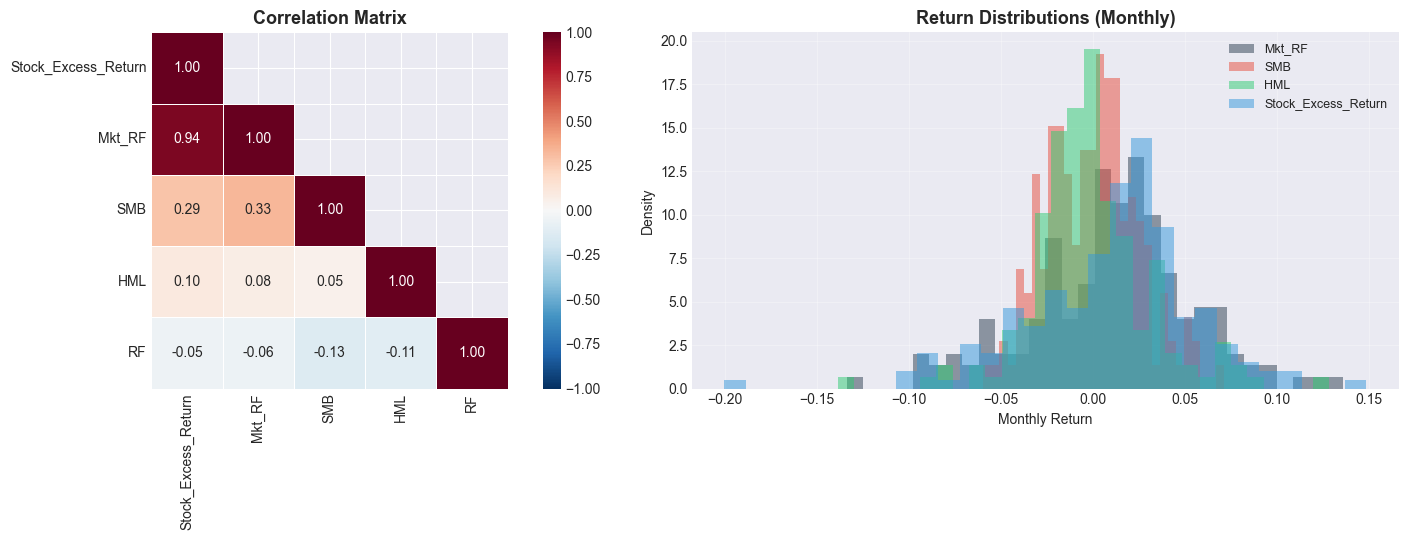

In [7]:
# ============================================================================
# Visualize: Correlation heatmap + factor distributions
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(16, 5.5))

# --- Left: Correlation heatmap ---
numeric_cols = df.select_dtypes(include=[np.number]).columns
corr_matrix = df[numeric_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            mask=mask, square=True, ax=axes[0], vmin=-1, vmax=1,
            linewidths=0.5)
axes[0].set_title('Correlation Matrix', fontweight='bold', fontsize=13)

# --- Right: Distribution of each factor + stock excess return ---
plot_cols = [c for c in ['Mkt_RF', 'SMB', 'HML', 'Stock_Excess_Return'] if c in df.columns]
colors = ['#2c3e50', '#e74c3c', '#2ecc71', '#3498db']
for col, color in zip(plot_cols, colors):
    axes[1].hist(df[col].dropna(), bins=30, alpha=0.5, color=color, label=col, density=True)
axes[1].set_title('Return Distributions (Monthly)', fontweight='bold', fontsize=13)
axes[1].set_xlabel('Monthly Return')
axes[1].set_ylabel('Density')
axes[1].legend(fontsize=9)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Interpreting the Descriptive Statistics

The exact numbers you see will depend on the data downloaded from Yahoo Finance. Here are the key things to look for:

**Key Observations:**

**Count (n)**: Check how many months of data we have. With ~168 months (2010–2023), we have a solid sample for reliable inference.

**Mean (Average Returns)**:
- **Mkt_RF**: The average monthly market excess return. Multiply by 12 for a rough annualized figure (or compute $(1 + \bar{r})^{12} - 1$ for the compound annualized return).
- **Stock_Excess_Return**: Since SPY tracks the broad US market, its mean excess return should be close to the Mkt_RF mean.

**Standard Deviation (Volatility)**:
- **Mkt_RF** and **Stock_Excess_Return**: For a broad US market ETF like SPY, these should be similar. Multiply monthly std dev by $\sqrt{12}$ for an annualized approximation.
- A typical annualized US equity volatility is around 15–20%.

**Range (Min to Max)**:
- Look for extreme months (e.g., the COVID crash in March 2020 will appear as a large negative).
- Even diversified ETFs experience significant monthly swings.

**The Correlation Matrix** shows how variables move together (scale: -1 to +1):

**Between Factors**:
- Mkt-RF vs SMB: Typically weak to moderate (small and large caps move somewhat together)
- Mkt-RF vs HML: Typically near zero (market and value effects are largely independent)
- SMB vs HML: Typically near zero (confirming they capture different risks)

**SPY's Correlations**:
- Mkt-RF vs SPY: Should be **very high** (close to 1), since SPY tracks the US market that the Mkt-RF factor is derived from. This is exactly what we expect!
- SMB vs SPY: Should be near zero or slightly negative — a large-cap-heavy index has limited small-cap exposure.
- HML vs SPY: Should be near zero — a market-cap-weighted index has no particular value tilt.

In [8]:
# Manual calculation of statistics for Mkt-RF
mkt_returns = df['Mkt_RF'].values
n = len(mkt_returns)

# Calculate mean
mean = mkt_returns.sum() / n

# Calculate standard deviation
deviations = mkt_returns - mean
squared_deviations = deviations ** 2
variance = squared_deviations.sum() / (n - 1)
std_dev = np.sqrt(variance)

# Calculate quartiles and range
min_val = mkt_returns.min()
q1 = np.percentile(mkt_returns, 25)
median = np.percentile(mkt_returns, 50)
q3 = np.percentile(mkt_returns, 75)
max_val = mkt_returns.max()
iqr = q3 - q1

# Results
print("Manual Calculation Results (Mkt-RF):")
print(f"Count: {n}")
print(f"Mean: {mean:.6f} ({mean:.4%} monthly, {(1 + mean)**12 - 1:.4%} annualized)")
print(f"Std Dev: {std_dev:.6f} ({std_dev:.4%} monthly, {std_dev * np.sqrt(12):.2%} annualized)")
print(f"Min: {min_val:.6f} ({min_val:.2%})")
print(f"Q1: {q1:.6f} ({q1:.2%})")
print(f"Median: {median:.6f} ({median:.2%})")
print(f"Q3: {q3:.6f} ({q3:.2%})")
print(f"Max: {max_val:.6f} ({max_val:.2%})")
print(f"IQR: {iqr:.6f}")

# Manual calculation of correlation
mkt = df['Mkt_RF'].values
stock = df['Stock_Excess_Return'].values
mkt_mean = mkt.mean()
stock_mean = stock.mean()
cov_numerator = ((mkt - mkt_mean) * (stock - stock_mean)).sum()
covariance = cov_numerator / (n - 1)
mkt_std = df['Mkt_RF'].std()
stock_std = df['Stock_Excess_Return'].std()
correlation = covariance / (mkt_std * stock_std)

print(f"\nManual Correlation (Mkt-RF vs Stock_Excess_Return):")
print(f"Covariance: {covariance:.6f}")
print(f"Correlation: {correlation:.6f}")
print(f"Verification (pandas): {df['Mkt_RF'].corr(df['Stock_Excess_Return']):.6f}")


Manual Calculation Results (Mkt-RF):
Count: 167
Mean: 0.010331 (1.0331% monthly, 13.1266% annualized)
Std Dev: 0.044440 (4.4440% monthly, 15.39% annualized)
Min: -0.133700 (-13.37%)
Q1: -0.016600 (-1.66%)
Median: 0.013400 (1.34%)
Q3: 0.034650 (3.46%)
Max: 0.136000 (13.60%)
IQR: 0.051250

Manual Correlation (Mkt-RF vs Stock_Excess_Return):
Covariance: 0.001942
Correlation: 0.944426
Verification (pandas): 0.944426


### Understanding These Manual Calculations

The code above recalculates statistics "from scratch" using the raw formulas: mean = sum/count, standard deviation via $\sqrt{\sum(x_i - \bar{x})^2 / (n-1)}$, covariance, and correlation. This is the same approach used on 5 data points in the [Statistical Foundations](01_Statistical_Foundations.ipynb) notebook (Sections 1–2) — now applied at scale to real market data. The pandas `.describe()` and `.corr()` methods compute exactly the same quantities.

**Why These Matter for the Fama-French Model:**
1. **Mean** — expected excess returns, i.e., compensation for taking risk
2. **Standard deviation** — volatility / risk level of each factor
3. **Correlation** — whether factors capture *different* risks (low correlation = good: the factors are not redundant)

For SPY vs Mkt-RF specifically, we expect correlation close to 1.0, since SPY tracks the very market that the Mkt-RF factor is derived from.

Let's now use these factors in a regression model to explain stock returns...

In [ ]:
# Visualize the time series of returns
fig, axes = plt.subplots(3, 2, figsize=(14, 12))

# ETF Returns (one subplot per ETF)
colors_etf = {'SPY': 'darkblue', 'IWN': 'darkorange', 'VTV': 'darkgreen'}
for ax, (ticker, label) in zip(axes[:, 0], etf_tickers.items()):
    etf_df = etf_dataframes[ticker]
    ax.plot(etf_df.index, etf_df['Stock_Excess_Return']*100,
            linewidth=1.5, color=colors_etf[ticker])
    ax.set_title(f'{label} - Excess Returns', fontsize=11, fontweight='bold')
    ax.set_ylabel('Return (%)', fontsize=10)
    ax.grid(True, alpha=0.3)

# Fama-French Factors
axes[0, 1].plot(df.index, df['Mkt_RF']*100, linewidth=1.5, color='darkred')
axes[0, 1].set_title('Market Risk Premium (Mkt-RF)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Return (%)', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)

axes[1, 1].plot(df.index, df['SMB']*100, linewidth=1.5, color='teal')
axes[1, 1].set_title('SMB Factor (Size Effect)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Return (%)', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)

axes[2, 1].plot(df.index, df['HML']*100, linewidth=1.5, color='purple')
axes[2, 1].set_title('HML Factor (Value Effect)', fontsize=11, fontweight='bold')
axes[2, 1].set_ylabel('Return (%)', fontsize=10)
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fama_french_timeseries.png', dpi=100, bbox_inches='tight')
plt.show()

print("Time series visualization created.")

---

## Section 4: Understanding Excess Returns and Regression Concepts

### What are Excess Returns?

In the Fama-French model, we don't use raw returns directly. Instead, we use **excess returns**, which are the returns on an investment minus the **risk-free rate**.

The formula is:

$$\text{Excess Return} = \text{Actual Return} - \text{Risk-Free Rate}$$

**Why do this?** The risk-free rate represents the return you could get with zero risk (like Treasury bonds). By subtracting it, we're asking: "How much extra return does this investment provide beyond what a safe investment would give?"

In our data:
- `Stock_Excess_Return` = The excess return on our ETF (already calculated)
- `Mkt_RF` = The market excess return (Market return minus risk-free rate)
- `SMB` and `HML` = Factor returns (already in excess form)

### Multiple Linear Regression: The Concept

We want to estimate a relationship like this:

$$y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + \beta_3 x_3 + \epsilon$$

In our case:
$$R_i - R_f = \alpha + \beta_1 (R_m - R_f) + \beta_2 \cdot SMB + \beta_3 \cdot HML + \epsilon$$

**What this means:**
- The ETF's excess return ($y$) depends on three factors ($x_1, x_2, x_3$)
- We want to find the coefficients ($\beta_0, \beta_1, \beta_2, \beta_3$) that best fit the data
- $\epsilon$ is the "leftover" part we can't explain—the error term


---

## Section 5: Ordinary Least Squares (OLS) Regression

### Applying the Normal Equations to Real Factor Data

OLS finds the coefficients that minimize the sum of squared errors. In matrix form:

$$\hat{\boldsymbol{\beta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$$

> **Full derivation:** See [Statistical Foundations](01_Statistical_Foundations.ipynb) (Section 5) for the scalar and matrix derivations of the normal equations with hand-checkable examples. Here we apply the same formula to real Fama-French data.

For our 3-factor model, the design matrix is:

$$\mathbf{X} = \begin{pmatrix}
1 & (R_m - R_f)_1 & SMB_1 & HML_1 \\
\vdots & \vdots & \vdots & \vdots \\
1 & (R_m - R_f)_n & SMB_n & HML_n
\end{pmatrix}$$

The first column of 1's gives us the intercept ($\alpha$). The code below walks through each matrix operation step by step on the actual data.

In [5]:
# Let's manually compute the OLS estimates using the normal equations
# to show exactly how this works in practice

print("="*70)
print("MANUAL OLS CALCULATION USING NORMAL EQUATIONS")
print("="*70)

# Step 1: Construct the design matrix X
# X has shape (n, 4): [intercept, Mkt_RF, SMB, HML]
X = np.column_stack([
    np.ones(len(df)),           # Column of 1's for the intercept
    df['Mkt_RF'].values,         # Market risk premium
    df['SMB'].values,            # SMB factor
    df['HML'].values             # HML factor
])

# Step 2: Extract the dependent variable (stock excess returns)
y = df['Stock_Excess_Return'].values

print(f"\nDesign matrix X shape: {X.shape}")
print(f"Dependent variable y shape: {y.shape}")
print(f"\nFirst 5 rows of X:")
print(f"   [Intercept]  [Mkt_RF]  [SMB]    [HML]")
print(X[:5])

# Step 3: Calculate X^T (transpose)
X_T = X.T
print(f"\nX^T shape: {X_T.shape}")

# Step 4: Calculate X^T * X
XTX = X_T @ X
print(f"\nX^T * X (shape {XTX.shape}):")
print(XTX)

# Step 5: Calculate (X^T * X)^-1
XTX_inv = np.linalg.inv(XTX)
print(f"\n(X^T * X)^-1:")
print(XTX_inv)

# Step 6: Calculate X^T * y
XTy = X_T @ y
print(f"\nX^T * y:")
print(XTy)

# Step 7: Calculate beta_hat = (X^T * X)^-1 * X^T * y
beta_hat = XTX_inv @ XTy

print("\n" + "="*70)
print("ESTIMATED COEFFICIENTS (β̂)")
print("="*70)
print(f"Alpha (α̂):          {beta_hat[0]:.6f} (intercept)")
print(f"Beta MKT (β̂_MKT):   {beta_hat[1]:.6f} (market sensitivity)")
print(f"Beta SMB (β̂_SMB):   {beta_hat[2]:.6f} (size sensitivity)")
print(f"Beta HML (β̂_HML):   {beta_hat[3]:.6f} (value sensitivity)")

# Remember: These are the "true" parameters we used to generate the data
# We will verify these manual estimates match the statsmodels output in the next section.
print("\nNote: We will compare these manual estimates with the statsmodels")
print("output in the next section to confirm they are identical.")

MANUAL OLS CALCULATION USING NORMAL EQUATIONS

Design matrix X shape: (167, 4)
Dependent variable y shape: (167,)

First 5 rows of X:
   [Intercept]  [Mkt_RF]  [SMB]    [HML]
[[ 1.     -0.0335  0.0043  0.0033]
 [ 1.      0.0339  0.0118  0.0318]
 [ 1.      0.063   0.0146  0.0219]
 [ 1.      0.0199  0.0484  0.0296]
 [ 1.     -0.079   0.0013 -0.0248]]

X^T shape: (4, 167)

X^T * X (shape (4, 4)):
[[ 1.6700000e+02  1.7253000e+00 -6.6000000e-02 -2.3120000e-01]
 [ 1.7253000e+00  3.4565291e-01  5.9908430e-02  1.6024510e-02]
 [-6.6000000e-02  5.9908430e-02  1.0062620e-01  7.2894200e-03]
 [-2.3120000e-01  1.6024510e-02  7.2894200e-03  1.7997772e-01]]

(X^T * X)^-1:
[[ 6.39253712e-03 -3.67837891e-02  2.53344839e-02  1.04608675e-02]
 [-3.67837891e-02  3.44554934e+00 -2.05584090e+00 -2.70765538e-01]
 [ 2.53344839e-02 -2.05584090e+00  1.11955741e+01 -2.37852030e-01]
 [ 1.04608675e-02 -2.70765538e-01 -2.37852030e-01  5.60342270e+00]]

X^T * y:
[1.7322797  0.34021695 0.05357857 0.02312363]

ESTIMATED

---

## Section 6: Fitting the Model with `statsmodels`

In Section 5 we computed the OLS coefficients manually using the normal equations. In practice, we use a statistical library — `statsmodels` — which does the same calculation and also computes many additional diagnostics automatically.

### What Does `statsmodels` Do?

When we call `sm.OLS(y, X).fit()`, the library:

1. **Computes the OLS estimates** $\hat{\boldsymbol{\beta}} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^T\mathbf{y}$ — exactly what we did by hand.
2. **Estimates the error variance** $\hat{\sigma}^2 = \frac{RSS}{n - k}$ from the residuals.
3. **Calculates many additional statistics** — standard errors, t-statistics, p-values, $R^2$, and more.

For now, we'll only verify that `statsmodels` produces the **same coefficients** as our manual calculation. This is an important sanity check: if both methods agree, we know our math is correct.

The additional statistics (R-squared, standard errors, t-statistics, p-values, etc.) will be introduced **one at a time** in the sections that follow, so you can understand each one properly before moving on.

In [6]:
# Fit the Fama-French 3-factor regression model using statsmodels

# Prepare the data
y = df['Stock_Excess_Return'].values
X_factors = df[['Mkt_RF', 'SMB', 'HML']].values

# Add constant (intercept) term
X_with_const = sm.add_constant(X_factors)

# Fit the OLS model
model = sm.OLS(y, X_with_const)
results = model.fit()

# -----------------------------------------------------------------------
# Verify: do the statsmodels coefficients match our manual calculation?
# -----------------------------------------------------------------------
print("="*70)
print("VERIFICATION: MANUAL vs STATSMODELS COEFFICIENTS")
print("="*70)

labels = ['Alpha (intercept)', 'Beta_MKT', 'Beta_SMB', 'Beta_HML']
print(f"\n{'Coefficient':<22s}  {'Manual':>12s}  {'statsmodels':>12s}  {'Match?':>8s}")
print("-"*60)
for i, name in enumerate(labels):
    manual = beta_hat[i]
    sm_coef = results.params[i]
    match = np.isclose(manual, sm_coef)
    print(f"{name:<22s}  {manual:12.6f}  {sm_coef:12.6f}  {'Yes' if match else 'NO':>8s}")

print(f"\nAll coefficients match: {np.allclose(beta_hat, results.params)}")
print("\nThe statsmodels results object also contains standard errors,")
print("t-statistics, p-values, R-squared, and many other diagnostics.")
print("We will explore each of these in the sections that follow.")

VERIFICATION: MANUAL vs STATSMODELS COEFFICIENTS

Coefficient                   Manual   statsmodels    Match?
------------------------------------------------------------
Alpha (intercept)           0.000158      0.000158       Yes
Beta_MKT                    0.992104      0.992104       Yes
Beta_SMB                   -0.061203     -0.061203       Yes
Beta_HML                    0.042830      0.042830       Yes

All coefficients match: True

The statsmodels results object also contains standard errors,
t-statistics, p-values, R-squared, and many other diagnostics.
We will explore each of these in the sections that follow.


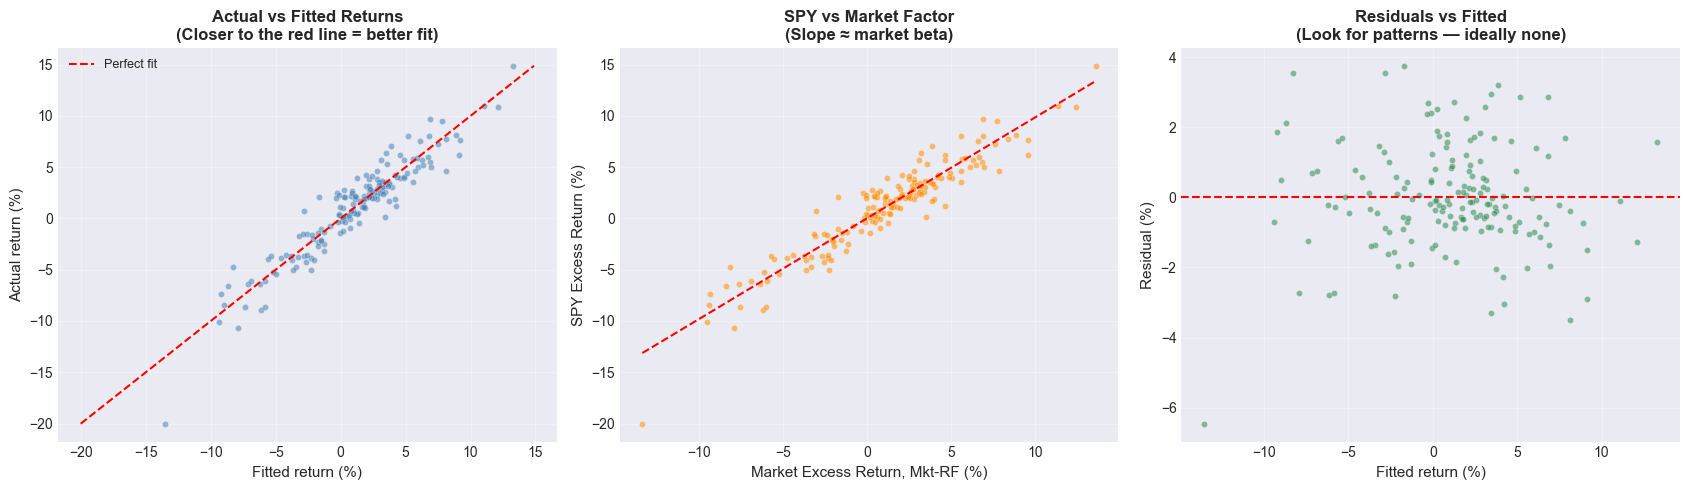

Left:   Points near the 45° line → model captures most variation.
Center: The steep slope confirms SPY moves nearly 1-for-1 with the market.
Right:  No visible pattern in residuals → model specification looks reasonable.


In [9]:
# ============================================================================
# Visualize the regression: fitted vs actual + scatter against main factor
# ============================================================================
# Seeing the regression visually builds intuition that tables alone cannot.

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# Panel 1: Fitted vs Actual (the classic regression-quality scatter)
fitted = results.fittedvalues * 100   # convert to %
actual = y * 100
axes[0].scatter(fitted, actual, s=20, alpha=0.55, color='steelblue', edgecolors='white', linewidth=0.3)
lo, hi = min(fitted.min(), actual.min()), max(fitted.max(), actual.max())
axes[0].plot([lo, hi], [lo, hi], color='red', linewidth=1.5, linestyle='--', label='Perfect fit')
axes[0].set_xlabel('Fitted return (%)', fontsize=11)
axes[0].set_ylabel('Actual return (%)', fontsize=11)
axes[0].set_title('Actual vs Fitted Returns\n(Closer to the red line = better fit)', fontweight='bold')
axes[0].legend(fontsize=9)
axes[0].grid(True, alpha=0.3)

# Panel 2: Excess Return vs Mkt-RF (the dominant factor)
mkt_vals = df['Mkt_RF'].values * 100
axes[1].scatter(mkt_vals, actual, s=20, alpha=0.55, color='darkorange', edgecolors='white', linewidth=0.3)
# Simple bivariate OLS line for visual reference
slope_simple = np.polyfit(mkt_vals, actual, 1)
x_line = np.linspace(mkt_vals.min(), mkt_vals.max(), 100)
axes[1].plot(x_line, np.polyval(slope_simple, x_line), color='red', linewidth=1.5, linestyle='--')
axes[1].set_xlabel('Market Excess Return, Mkt-RF (%)', fontsize=11)
axes[1].set_ylabel('SPY Excess Return (%)', fontsize=11)
axes[1].set_title('SPY vs Market Factor\n(Slope ≈ market beta)', fontweight='bold')
axes[1].grid(True, alpha=0.3)

# Panel 3: Residuals vs Fitted (preview of diagnostics)
resid = results.resid * 100
axes[2].scatter(fitted, resid, s=20, alpha=0.55, color='seagreen', edgecolors='white', linewidth=0.3)
axes[2].axhline(0, color='red', linewidth=1.5, linestyle='--')
axes[2].set_xlabel('Fitted return (%)', fontsize=11)
axes[2].set_ylabel('Residual (%)', fontsize=11)
axes[2].set_title('Residuals vs Fitted\n(Look for patterns — ideally none)', fontweight='bold')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Left:   Points near the 45° line → model captures most variation.")
print("Center: The steep slope confirms SPY moves nearly 1-for-1 with the market.")
print("Right:  No visible pattern in residuals → model specification looks reasonable.")

---

## Section 7: Model Performance Metrics

### Understanding R-squared and Other Fit Statistics

Before diving into the individual coefficients, let's assess how well the model fits the data overall. These metrics don't depend on the standard error method, so they're safe to interpret right away.

### The R-squared Formula

$$R^2 = 1 - \frac{RSS}{TSS}$$

**Where:**
- $RSS$ (Residual Sum of Squares) = $\sum_{i=1}^{n} (y_i - \hat{y}_i)^2$ = Sum of squared residuals
- $TSS$ (Total Sum of Squares) = $\sum_{i=1}^{n} (y_i - \bar{y})^2$ = Total variation in $y$
- $\bar{y}$ = Mean of the dependent variable

**Intuition:**
- $TSS$ measures how much $y$ varies around its mean (total variation to explain)
- $RSS$ measures how much unexplained variation remains after fitting the model
- $R^2$ tells us what fraction of the total variation is explained by the model
- $R^2$ ranges from 0 to 1; higher is better

### Adjusted R-squared

The problem with $R^2$ is that adding more variables always increases it (even bad variables). Adjusted $R^2$ penalizes for the number of variables:

$$\bar{R}^2 = 1 - \frac{RSS/(n-k)}{TSS/(n-1)} = 1 - \frac{(1-R^2)(n-1)}{n-k}$$

**Where:**
- $n$ = number of observations
- $k$ = number of parameters (including intercept)
- The denominator $(n-k)$ is called "degrees of freedom"

In [10]:
# Calculate model performance metrics
print("="*70)
print("MODEL PERFORMANCE METRICS - MANUAL CALCULATIONS")
print("="*70)

# Get predictions and residuals
y_actual = df['Stock_Excess_Return'].values
y_pred = np.asarray(results.fittedvalues)
residuals = np.asarray(results.resid)

# Calculate means
y_mean = np.mean(y_actual)

# Calculate sums of squares
TSS = np.sum((y_actual - y_mean)**2)           # Total Sum of Squares
RSS = np.sum(residuals**2)                     # Residual Sum of Squares
ESS = np.sum((y_pred - y_mean)**2)             # Explained Sum of Squares

print(f"\nNOTE: TSS = RSS + ESS (always true)")
print(f"TSS = {TSS:.8f}")
print(f"RSS = {RSS:.8f}")
print(f"ESS = {ESS:.8f}")
print(f"TSS = RSS + ESS? {np.isclose(TSS, RSS + ESS)}")

# Calculate R-squared
R2 = 1 - (RSS / TSS)
print(f"\n1. R-SQUARED (R²)")
print(f"   Formula: R² = 1 - (RSS / TSS)")
print(f"   Calculation: R² = 1 - ({RSS:.6f} / {TSS:.6f})")
print(f"   R² = {R2:.6f}")
print(f"   Interpretation: {R2*100:.2f}% of the variation in stock returns is")
print(f"   explained by the three Fama-French factors.")

# Calculate Adjusted R-squared
n = len(y_actual)
k = 4  # 4 parameters: alpha, beta_mkt, beta_smb, beta_hml
adj_R2 = 1 - ((1 - R2) * (n - 1) / (n - k))
print(f"\n2. ADJUSTED R-SQUARED (R̄²)")
print(f"   Formula: R̄² = 1 - ((1 - R²) × (n-1) / (n-k))")
print(f"   Where n = {n} observations, k = {k} parameters")
print(f"   Calculation: R̄² = 1 - ((1 - {R2:.4f}) × {n-1} / {n-k})")
print(f"   R̄² = {adj_R2:.6f}")
print(f"   Interpretation: After adjusting for the number of variables,")
print(f"   {adj_R2*100:.2f}% of variation is explained.")

# Calculate standard deviation of regression
sigma_hat_sq = RSS / (n - k)
sigma_hat = np.sqrt(sigma_hat_sq)
print(f"\n3. RESIDUAL STANDARD ERROR (σ̂)")
print(f"   Formula: σ̂² = RSS / (n - k)")
print(f"   Calculation: σ̂² = {RSS:.6f} / {n - k}")
print(f"   σ̂² = {sigma_hat_sq:.8f}")
print(f"   σ̂ = {sigma_hat:.6f}")
print(f"   Interpretation: On average, predictions are off by {sigma_hat:.6f}")
print(f"   ({sigma_hat*100:.4f}% per month in this case).")

# Calculate F-statistic
MSR = ESS / (k - 1)  # Mean Squared Regression
MSE = RSS / (n - k)  # Mean Squared Error
F_stat = MSR / MSE
# Calculate p-value for F-statistic
from scipy.stats import f
p_value_F = 1 - f.cdf(F_stat, k-1, n-k)
print(f"\n4. F-STATISTIC")
print(f"   Formula: F = (ESS / (k-1)) / (RSS / (n-k)) = MSR / MSE")
print(f"   MSR = {MSR:.8f}, MSE = {MSE:.8f}")
print(f"   F-statistic = {F_stat:.4f}")
print(f"   p-value = {p_value_F:.2e}")
print(f"   Interpretation: This tests the null hypothesis that ALL coefficients")
print(f"   (except intercept) equal zero. If p-value < 0.05, we reject this,")
print(f"   meaning the model IS statistically significant.")
if p_value_F < 0.05:
    print(f"   The model IS statistically significant (p < 0.05)")
else:
    print(f"   The model is NOT statistically significant")

# Compare with statsmodels values
print("\n" + "="*70)
print("COMPARISON WITH STATSMODELS OUTPUT")
print("="*70)
print(f"Our R²:               {R2:.6f}")
print(f"Statsmodels R²:       {results.rsquared:.6f}")
print(f"Match? {np.isclose(R2, results.rsquared)}")
print(f"\nOur Adjusted R²:      {adj_R2:.6f}")
print(f"Statsmodels Adj R²:   {results.rsquared_adj:.6f}")
print(f"Match? {np.isclose(adj_R2, results.rsquared_adj)}")
print(f"\nOur F-statistic:      {F_stat:.4f}")
print(f"Statsmodels F-stat:   {results.fvalue:.4f}")
print(f"Match? {np.isclose(F_stat, results.fvalue)}")

MODEL PERFORMANCE METRICS - MANUAL CALCULATIONS

NOTE: TSS = RSS + ESS (always true)
TSS = 0.35529858
RSS = 0.03775092
ESS = 0.31754766
TSS = RSS + ESS? True

1. R-SQUARED (R²)
   Formula: R² = 1 - (RSS / TSS)
   Calculation: R² = 1 - (0.037751 / 0.355299)
   R² = 0.893749
   Interpretation: 89.37% of the variation in stock returns is
   explained by the three Fama-French factors.

2. ADJUSTED R-SQUARED (R̄²)
   Formula: R̄² = 1 - ((1 - R²) × (n-1) / (n-k))
   Where n = 167 observations, k = 4 parameters
   Calculation: R̄² = 1 - ((1 - 0.8937) × 166 / 163)
   R̄² = 0.891793
   Interpretation: After adjusting for the number of variables,
   89.18% of variation is explained.

3. RESIDUAL STANDARD ERROR (σ̂)
   Formula: σ̂² = RSS / (n - k)
   Calculation: σ̂² = 0.037751 / 163
   σ̂² = 0.00023160
   σ̂ = 0.015218
   Interpretation: On average, predictions are off by 0.015218
   (1.5218% per month in this case).

4. F-STATISTIC
   Formula: F = (ESS / (k-1)) / (RSS / (n-k)) = MSR / MSE
   MS

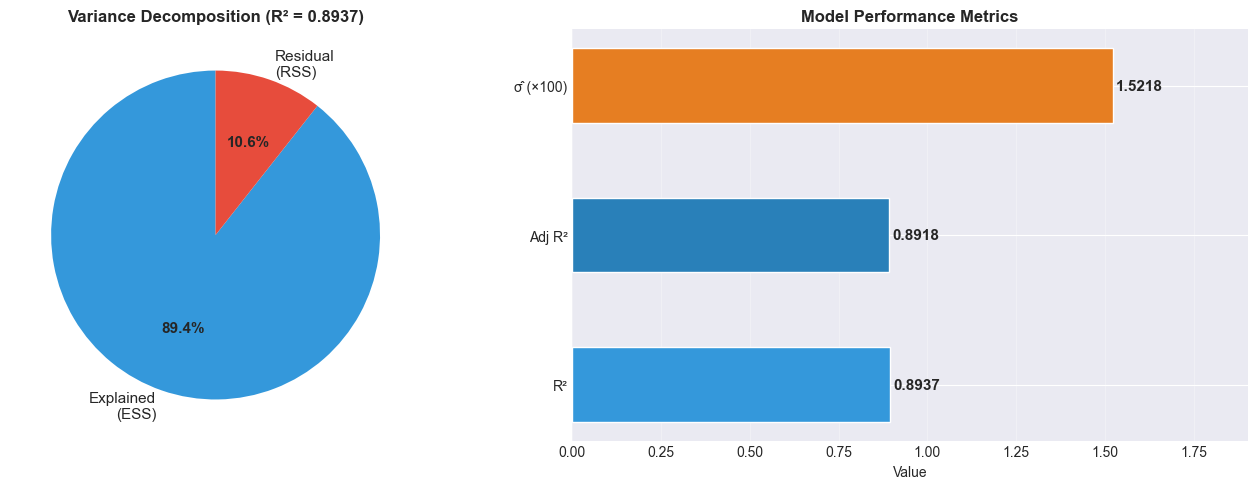

In [11]:
# ============================================================================
# Visualize: Model performance metrics
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# --- Left: Variance decomposition (TSS = ESS + RSS) ---
ax = axes[0]
labels = ['Explained\n(ESS)', 'Residual\n(RSS)']
sizes = [ESS, RSS]
colors_pie = ['#3498db', '#e74c3c']
wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors_pie,
                                   autopct='%1.1f%%', startangle=90,
                                   textprops={'fontsize': 11})
for at in autotexts:
    at.set_fontweight('bold')
ax.set_title(f'Variance Decomposition (R² = {R2:.4f})', fontweight='bold', fontsize=12)

# --- Right: Key metrics summary ---
ax2 = axes[1]
metric_names = ['R²', 'Adj R²', f'σ̂ (×100)']
metric_vals = [R2, adj_R2, sigma_hat * 100]
bar_colors = ['#3498db', '#2980b9', '#e67e22']
bars = ax2.barh(metric_names, metric_vals, color=bar_colors, edgecolor='white', height=0.5)
for bar, val in zip(bars, metric_vals):
    ax2.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
             f'{val:.4f}', va='center', fontsize=11, fontweight='bold')
ax2.set_xlabel('Value')
ax2.set_title('Model Performance Metrics', fontweight='bold', fontsize=12)
ax2.set_xlim(0, max(metric_vals) * 1.25)
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

---

## Section 8: Validating Regression Assumptions and Diagnostics

### Why This Section Matters

The regression in Section 6 gave us coefficient estimates ($\hat{\alpha}$, $\hat{\beta}_{MKT}$, etc.) and the performance metrics in Section 7 told us how well the model fits. But those numbers come with a hidden catch: **the standard errors, t-statistics, and p-values printed alongside the coefficients are only trustworthy if certain assumptions about the error term hold.**

If those assumptions fail — and they often do for financial data — then:
- The coefficient estimates themselves are typically still fine (unbiased and consistent).
- But the **uncertainty measures are wrong**: standard errors tend to be too small, t-statistics too large, and p-values too optimistic. In other words, you might conclude a factor is statistically significant when it really isn't.

> **Connection to earlier notebooks:** The [Time-Series Foundations](02_Time_Series_Foundations.ipynb) notebook showed empirically that financial return data is approximately stationary (Section 2), has weak autocorrelation but strong volatility clustering (Sections 3–4), and satisfies mixing conditions (Section 5). The summary "assumption stack" (Section 6) previewed exactly which assumptions hold and which fail. Here we check the same assumptions directly on the Fama-French regression residuals.

This section checks the assumptions; the **next** section (Section 9) will show how to fix things when they fail.

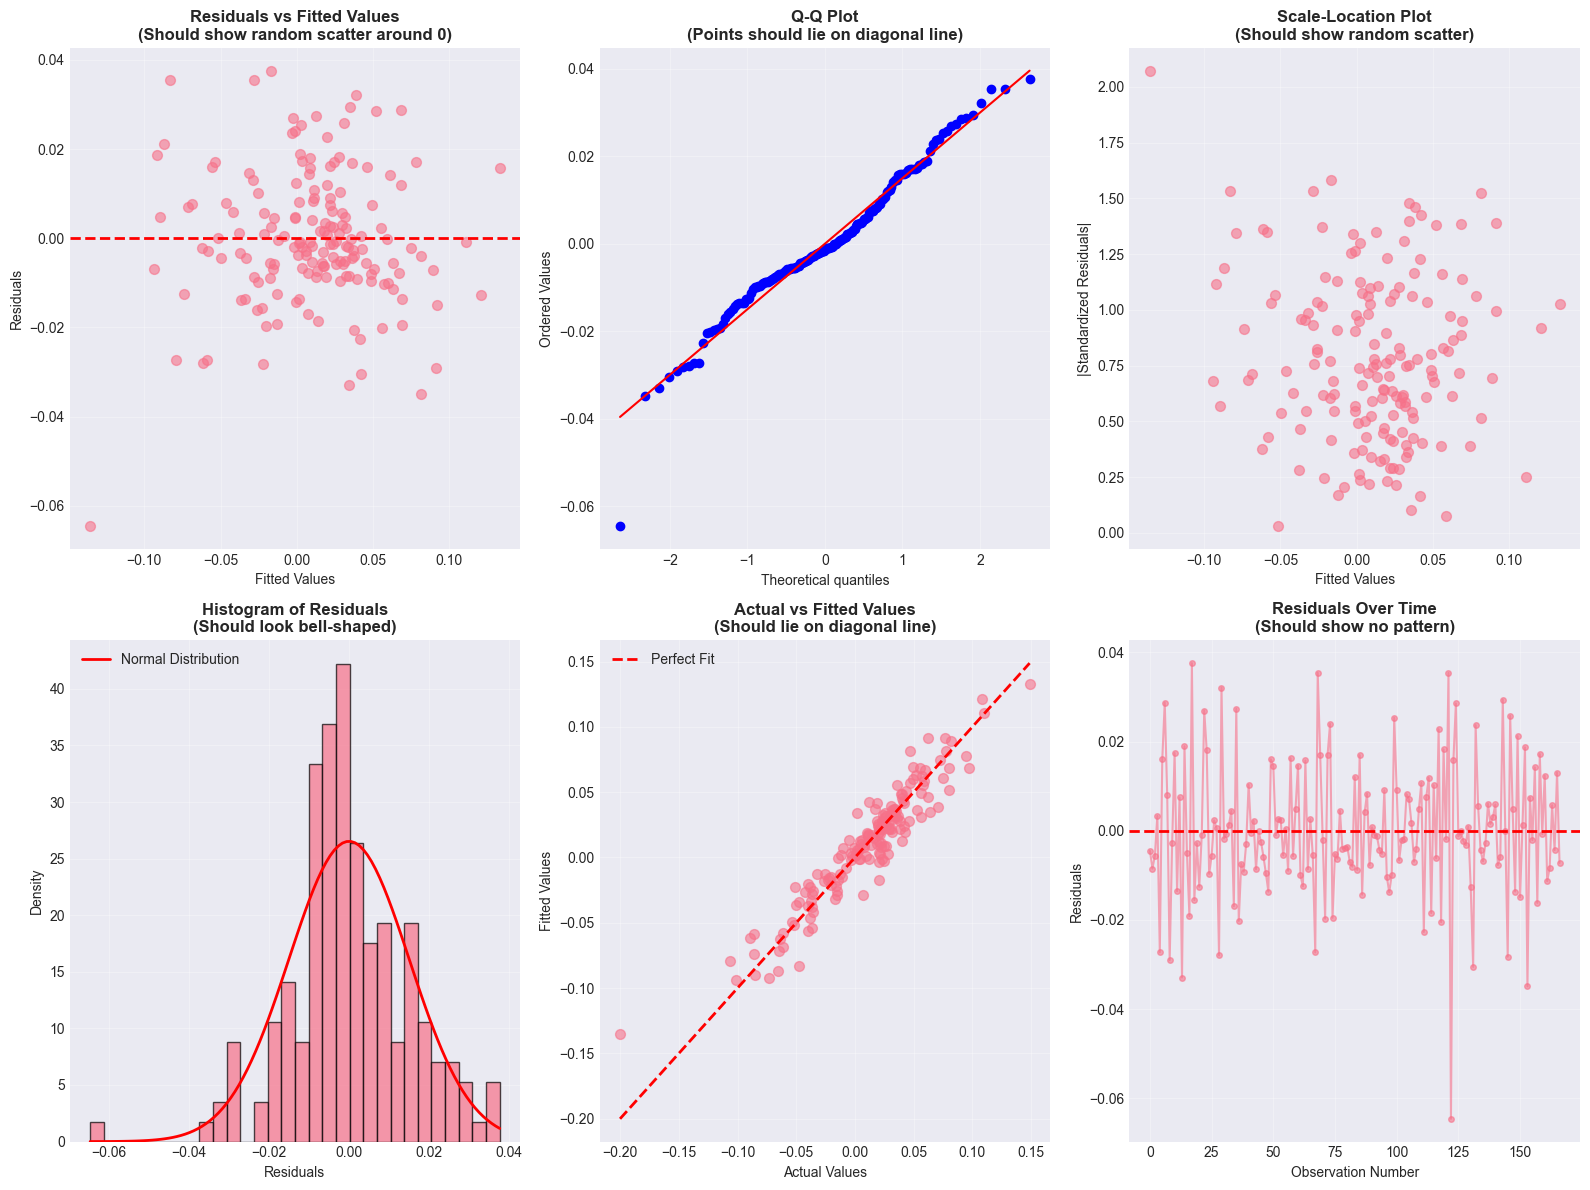

Diagnostic plots created.


In [12]:
# Create diagnostic plots
fig = plt.figure(figsize=(16, 12))

# Get residuals and fitted values
residuals = np.asarray(results.resid)
fitted_values = np.asarray(results.fittedvalues)
y_actual = df['Stock_Excess_Return'].values

# 1. Residuals vs Fitted Values (checks linearity and homoscedasticity)
ax1 = plt.subplot(2, 3, 1)
ax1.scatter(fitted_values, residuals, alpha=0.6, s=50)
ax1.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Residuals vs Fitted Values\n(Should show random scatter around 0)', fontweight='bold')
ax1.grid(True, alpha=0.3)

# 2. Q-Q Plot (checks normality of residuals)
ax2 = plt.subplot(2, 3, 2)
stats.probplot(residuals, dist="norm", plot=ax2)
ax2.set_title('Q-Q Plot\n(Points should lie on diagonal line)', fontweight='bold')
ax2.grid(True, alpha=0.3)

# 3. Scale-Location Plot (checks homoscedasticity)
ax3 = plt.subplot(2, 3, 3)
standardized_residuals = residuals / np.std(residuals)
ax3.scatter(fitted_values, np.sqrt(np.abs(standardized_residuals)), alpha=0.6, s=50)
ax3.set_xlabel('Fitted Values')
ax3.set_ylabel('|Standardized Residuals|')
ax3.set_title('Scale-Location Plot\n(Should show random scatter)', fontweight='bold')
ax3.grid(True, alpha=0.3)

# 4. Histogram of residuals (checks normality)
ax4 = plt.subplot(2, 3, 4)
ax4.hist(residuals, bins=30, edgecolor='black', alpha=0.7, density=True)
# Overlay normal distribution
mu, sigma = residuals.mean(), residuals.std()
x = np.linspace(residuals.min(), residuals.max(), 100)
ax4.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', linewidth=2, label='Normal Distribution')
ax4.set_xlabel('Residuals')
ax4.set_ylabel('Density')
ax4.set_title('Histogram of Residuals\n(Should look bell-shaped)', fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

# 5. Actual vs Fitted
ax5 = plt.subplot(2, 3, 5)
ax5.scatter(y_actual, fitted_values, alpha=0.6, s=50)
min_val = min(y_actual.min(), fitted_values.min())
max_val = max(y_actual.max(), fitted_values.max())
ax5.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Fit')
ax5.set_xlabel('Actual Values')
ax5.set_ylabel('Fitted Values')
ax5.set_title('Actual vs Fitted Values\n(Should lie on diagonal line)', fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 6. Residuals over time (checks independence)
ax6 = plt.subplot(2, 3, 6)
ax6.plot(range(len(residuals)), residuals, marker='o', linestyle='-', alpha=0.6, markersize=4)
ax6.axhline(y=0, color='r', linestyle='--', linewidth=2)
ax6.set_xlabel('Observation Number')
ax6.set_ylabel('Residuals')
ax6.set_title('Residuals Over Time\n(Should show no pattern)', fontweight='bold')
ax6.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fama_french_diagnostics.png', dpi=100, bbox_inches='tight')
plt.show()

print("Diagnostic plots created.")

### Formal Statistical Tests for Assumptions

Visual inspection gives us intuition, but formal statistical tests provide rigorous evidence. Each test below has a null hypothesis ($H_0$) representing the "ideal" scenario and an alternative that flags a violation.

In [13]:
print("="*70)
print("FORMAL TESTS FOR REGRESSION ASSUMPTIONS")
print("="*70)

# 1. Normality Test: Jarque-Bera
print("\n1. JARQUE-BERA TEST FOR NORMALITY")
print("   Null Hypothesis (H0): Residuals are normally distributed")
print("   Alternative Hypothesis (H1): Residuals are NOT normally distributed")
print("   Caveat: With ~100+ observations, JB can over-reject for financial")
print("   data that has mild fat tails (excess kurtosis), even when the")
print("   departure from normality is too small to meaningfully affect OLS.")
print("   This is one reason we use robust standard errors regardless.")
jb_result = jarque_bera(residuals)
jb_statistic, jb_pvalue = jb_result[0], jb_result[1]
print(f"   Test Statistic: {jb_statistic:.6f}")
print(f"   p-value: {jb_pvalue:.6f}")
if jb_pvalue > 0.05:
    print(f"   CONCLUSION: We fail to reject H0 (p > 0.05)")
    print(f"     Residuals appear to be normally distributed.")
else:
    print(f"   CONCLUSION: We reject H0 (p < 0.05)")
    print(f"     Residuals appear to NOT be normally distributed.")

# 2. Breusch-Pagan Test for Heteroscedasticity
print("\n2. BREUSCH-PAGAN TEST FOR HOMOSCEDASTICITY")
print("   Null Hypothesis (H0): Constant variance of residuals (homoscedasticity)")
print("   Alternative Hypothesis (H1): Variance is NOT constant (heteroscedasticity)")
from statsmodels.stats.diagnostic import het_breuschpagan
bp_test = het_breuschpagan(residuals, X_with_const)
bp_statistic, bp_pvalue = bp_test[0], bp_test[1]
print(f"   Test Statistic: {bp_statistic:.6f}")
print(f"   p-value: {bp_pvalue:.6f}")
if bp_pvalue > 0.05:
    print(f"   CONCLUSION: We fail to reject H0 (p > 0.05)")
    print(f"     The variance appears to be constant across fitted values.")
else:
    print(f"   CONCLUSION: We reject H0 (p < 0.05)")
    print(f"     There appears to be heteroscedasticity.")

# 3. Durbin-Watson Test for Autocorrelation
print("\n3. DURBIN-WATSON TEST FOR AUTOCORRELATION")
print("   Tests for correlation between consecutive residuals")
from statsmodels.stats.stattools import durbin_watson
dw_statistic = durbin_watson(residuals)
print(f"   Durbin-Watson Statistic: {dw_statistic:.6f}")
print(f"   Interpretation:")
print(f"      DW ~ 2: No autocorrelation (ideal)")
print(f"      DW < 2: Positive autocorrelation")
print(f"      DW > 2: Negative autocorrelation")
if 1.5 < dw_statistic < 2.5:
    print(f"   CONCLUSION: No significant autocorrelation detected.")
else:
    print(f"   CONCLUSION: Possible autocorrelation detected (DW = {dw_statistic:.4f})")

# 4. Variance Inflation Factor (VIF) for Multicollinearity
print("\n4. VARIANCE INFLATION FACTOR (VIF) FOR MULTICOLLINEARITY")
print("   VIF measures how much the variance of a coefficient is")
print("   inflated due to correlation with other variables.")
print("   Interpretation: VIF > 5 suggests multicollinearity problem")
print()
vif_values = []
for i in range(1, X_with_const.shape[1]):  # Skip the constant
    vif = variance_inflation_factor(X_with_const, i)
    var_name = ['Mkt_RF', 'SMB', 'HML'][i-1]
    vif_values.append((var_name, vif))
    print(f"   {var_name:10s}: VIF = {vif:.4f}", end="")
    if vif < 5:
        print(" (No multicollinearity)")
    else:
        print(" (MULTICOLLINEARITY WARNING)")

print("\n" + "="*70)
print("SUMMARY OF ASSUMPTIONS")
print("="*70)
print(f"Normality (Jarque-Bera):      {'PASS' if jb_pvalue > 0.05 else 'FAIL'}")
print(f"Homoscedasticity (BP test):   {'PASS' if bp_pvalue > 0.05 else 'FAIL'}")
print(f"Independence (Durbin-Watson): {'PASS' if 1.5 < dw_statistic < 2.5 else 'WARNING'}")
print(f"Multicollinearity (VIF):      {'PASS' if all(vif < 5 for _, vif in vif_values) else 'WARNING'}")

print("\nNote: Even if all tests pass, robust standard errors are still")
print("recommended for financial time-series data. Financial returns exhibit")
print("time-varying volatility (conditional heteroscedasticity) that the")
print("Breusch-Pagan test may not detect. This motivates the next section.")

FORMAL TESTS FOR REGRESSION ASSUMPTIONS

1. JARQUE-BERA TEST FOR NORMALITY
   Null Hypothesis (H0): Residuals are normally distributed
   Alternative Hypothesis (H1): Residuals are NOT normally distributed
   Caveat: With ~100+ observations, JB can over-reject for financial
   data that has mild fat tails (excess kurtosis), even when the
   departure from normality is too small to meaningfully affect OLS.
   This is one reason we use robust standard errors regardless.
   Test Statistic: 17.925123
   p-value: 0.000128
   CONCLUSION: We reject H0 (p < 0.05)
     Residuals appear to NOT be normally distributed.

2. BREUSCH-PAGAN TEST FOR HOMOSCEDASTICITY
   Null Hypothesis (H0): Constant variance of residuals (homoscedasticity)
   Alternative Hypothesis (H1): Variance is NOT constant (heteroscedasticity)
   Test Statistic: 16.583784
   p-value: 0.000861
   CONCLUSION: We reject H0 (p < 0.05)
     There appears to be heteroscedasticity.

3. DURBIN-WATSON TEST FOR AUTOCORRELATION
   Tests f

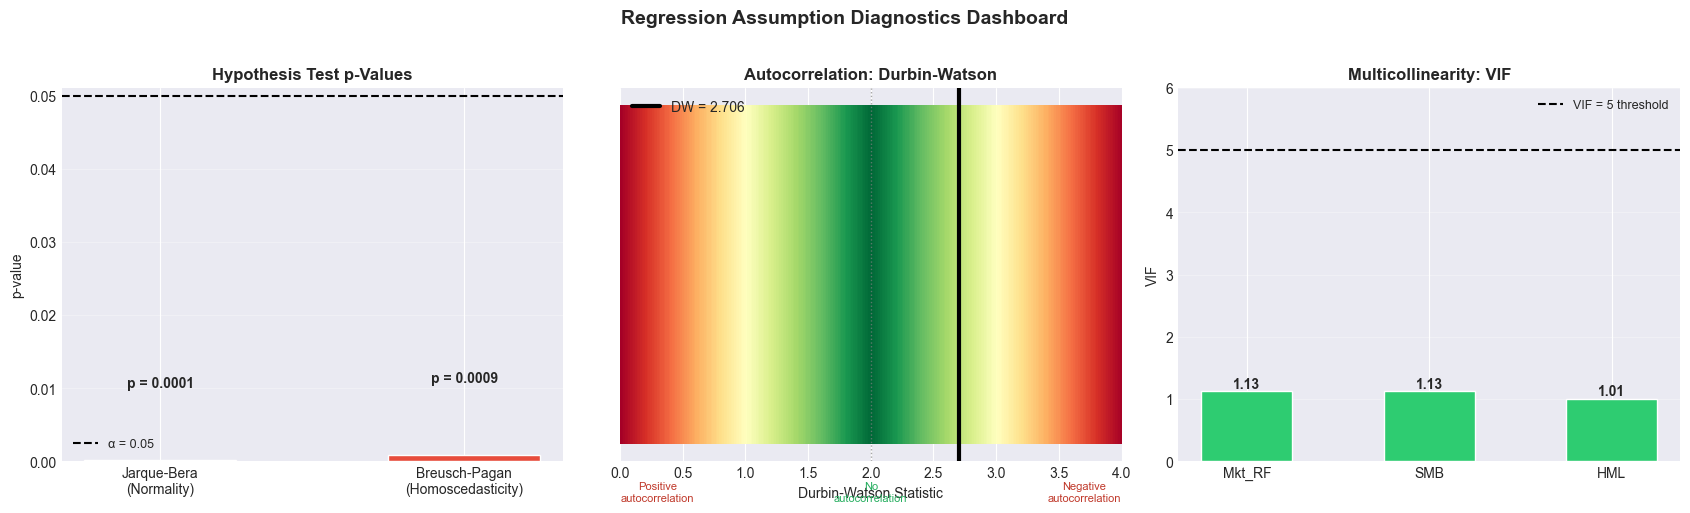

In [14]:
# ============================================================================
# Visualize: Assumption test dashboard
# ============================================================================

fig, axes = plt.subplots(1, 3, figsize=(17, 5))

# --- Panel 1: p-value summary for normality & homoscedasticity tests ---
test_names = ['Jarque-Bera\n(Normality)', 'Breusch-Pagan\n(Homoscedasticity)']
p_values = [jb_pvalue, bp_pvalue]
bar_colors = ['#2ecc71' if p > 0.05 else '#e74c3c' for p in p_values]

ax = axes[0]
bars = ax.bar(test_names, p_values, color=bar_colors, edgecolor='white', width=0.5)
ax.axhline(y=0.05, color='black', linestyle='--', linewidth=1.5, label='α = 0.05')
for bar, pv in zip(bars, p_values):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
            f'p = {pv:.4f}', ha='center', fontsize=10, fontweight='bold')
ax.set_ylabel('p-value')
ax.set_title('Hypothesis Test p-Values', fontweight='bold', fontsize=12)
ax.set_ylim(0, max(p_values) * 1.3 + 0.05)
ax.legend(fontsize=9)
ax.grid(True, alpha=0.3, axis='y')

# --- Panel 2: Durbin-Watson gauge ---
ax2 = axes[1]
dw_range = np.linspace(0, 4, 300)
# Color gradient: red at 0 and 4, green at 2
dw_colors_map = plt.cm.RdYlGn(1 - np.abs(dw_range - 2) / 2)
for i in range(len(dw_range) - 1):
    ax2.barh(0, dw_range[i+1] - dw_range[i], left=dw_range[i], height=0.6,
             color=dw_colors_map[i])
ax2.axvline(x=dw_statistic, color='black', linewidth=3, label=f'DW = {dw_statistic:.3f}')
ax2.axvline(x=2.0, color='gray', linewidth=1, linestyle=':', alpha=0.7)
ax2.set_xlim(0, 4)
ax2.set_yticks([])
ax2.set_xlabel('Durbin-Watson Statistic')
ax2.set_title('Autocorrelation: Durbin-Watson', fontweight='bold', fontsize=12)
ax2.legend(fontsize=10, loc='upper left')
ax2.text(0.3, -0.4, 'Positive\nautocorrelation', ha='center', fontsize=8, color='#c0392b')
ax2.text(2.0, -0.4, 'No\nautocorrelation', ha='center', fontsize=8, color='#27ae60')
ax2.text(3.7, -0.4, 'Negative\nautocorrelation', ha='center', fontsize=8, color='#c0392b')

# --- Panel 3: VIF bar chart ---
ax3 = axes[2]
vif_names = [name for name, _ in vif_values]
vif_vals = [vif for _, vif in vif_values]
vif_colors = ['#2ecc71' if v < 5 else '#e74c3c' for v in vif_vals]
bars3 = ax3.bar(vif_names, vif_vals, color=vif_colors, edgecolor='white', width=0.5)
ax3.axhline(y=5, color='black', linestyle='--', linewidth=1.5, label='VIF = 5 threshold')
for bar, v in zip(bars3, vif_vals):
    ax3.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.05,
            f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')
ax3.set_ylabel('VIF')
ax3.set_title('Multicollinearity: VIF', fontweight='bold', fontsize=12)
ax3.set_ylim(0, max(max(vif_vals) * 1.3, 6))
ax3.legend(fontsize=9)
ax3.grid(True, alpha=0.3, axis='y')

fig.suptitle('Regression Assumption Diagnostics Dashboard', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---

## Section 9: Robust Standard Errors — The Standard in Empirical Finance

### Why This Matters

The diagnostic tests above may or may not have flagged violations. But here's the key insight: **in financial time-series, we almost always use robust standard errors regardless of what the tests say.**

Why? Because:
- Financial returns exhibit **stochastic volatility** — variance changes over time. This is heteroscedasticity that simple tests may miss.
- Monthly returns can show **mild autocorrelation**, especially around regime changes.
- Classic OLS standard errors **assume** constant variance and no autocorrelation. If those assumptions fail, your coefficient estimates ($\hat{\beta}$) are still unbiased, but your **standard errors, t-statistics, p-values, and confidence intervals are wrong**.

> **Full derivation and intuition:** The sandwich formula (HC0), its small-sample variants (HC1–HC3), and the Newey-West extension are derived step-by-step — with hand calculations on a 5-observation dataset — in the [Statistical Foundations](01_Statistical_Foundations.ipynb) (Sections 6–9). The Monte Carlo evidence there demonstrates that classic OLS over-rejects under $H_0$ while Newey-West maintains the correct 5 % size.

### An Intuitive Picture: Why Autocorrelation Inflates False Positives

Imagine 100 monthly residuals. If each were truly independent, you'd have 100 independent pieces of information. But with **positive autocorrelation**, consecutive residuals are partially redundant: your 100 observations effectively contain **fewer than 100 independent pieces**. Classic OLS doesn't know this — it treats all 100 as fully independent, producing standard errors that are **too small**, t-statistics that are **too large**, and p-values that are **too optimistic**.

> This is exactly what Section 5 of the [Time-Series Foundations](02_Time_Series_Foundations.ipynb) notebook showed empirically: autocorrelation in returns decays fast enough for the mixing CLT to work, but is still present enough to distort classic standard errors.

### The Solution: Let the Data Determine the Variance

Instead of assuming a rigid error structure, robust methods let the residuals themselves determine the variance estimate:

| Method | Corrects for | When to use |
|--------|-------------|-------------|
| **HC1 / HC3** | Heteroscedasticity only | Cross-sectional data |
| **Newey-West HAC** | Heteroscedasticity **+** autocorrelation | **Time-series data** (our case) |

**For Fama-French regressions: always use Newey-West.** The code below compares all four methods side-by-side.

In [15]:
# Demonstrate the effects of heteroscedasticity and autocorrelation on standard errors
# and compare different robust methods

print("="*80)
print("COMPARING STANDARD ERROR ESTIMATES: CLASSIC VS. ROBUST METHODS")
print("="*80)

# Fit the model again (same as before)
y = df['Stock_Excess_Return'].values
X_factors = df[['Mkt_RF', 'SMB', 'HML']].values
X_with_const = sm.add_constant(X_factors)

model = sm.OLS(y, X_with_const)
results = model.fit()

# Get classic standard errors
print("\n1. CLASSIC OLS STANDARD ERRORS (assumes homoscedastic, independent errors)")
print("-" * 80)
classic_summary = results.summary()
print(classic_summary.tables[1])

classic_se = np.asarray(results.bse)

# HC1 (Heteroscedasticity Consistent)
print("\n" + "="*80)
print("2. HC1 STANDARD ERRORS (corrects for heteroscedasticity only)")
print("-" * 80)
results_hc1 = results.get_robustcov_results(cov_type='HC1')
print(results_hc1.summary().tables[1])

hc1_se = np.asarray(results_hc1.bse)

# HC3 Huber-White sandwich estimator
print("\n" + "="*80)
print("3. HC3 STANDARD ERRORS (alternative HC correction)")
print("-" * 80)
results_hc3 = results.get_robustcov_results(cov_type='HC3')
print(results_hc3.summary().tables[1])

hc3_se = np.asarray(results_hc3.bse)

# Newey-West Standard Errors (optimal lag selection)
print("\n" + "="*80)
print("4. NEWEY-WEST STANDARD ERRORS (corrects for heteroscedasticity + autocorrelation)")
print("-" * 80)

# Calculate appropriate lag length
n_obs = len(y)
lag_length = int(np.floor(4 * (n_obs / 100) ** (2/9)))
print(f"Sample size: {n_obs} observations")
print(f"Optimal lag length: {lag_length} (using Andrews formula)")

results_nw = results.get_robustcov_results(cov_type='HAC', maxlags=lag_length)
print(results_nw.summary().tables[1])

nw_se = np.asarray(results_nw.bse)

# Create comparison table
print("\n" + "="*80)
print("DETAILED COMPARISON OF STANDARD ERRORS")
print("="*80)

var_names = ['Intercept (a)', 'Mkt_RF (B_MKT)', 'SMB (B_SMB)', 'HML (B_HML)']
comparison_data = {
    'Variable': var_names,
    'Classic SE': classic_se,
    'HC1 SE': hc1_se,
    'HC3 SE': hc3_se,
    'Newey-West SE': nw_se,
    'HC1 % Change': (hc1_se - classic_se) / classic_se * 100,
    'NW % Change': (nw_se - classic_se) / classic_se * 100
}

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

print("\n" + "="*80)
print("INTERPRETING THE COMPARISON")
print("="*80)
print("""
% Change Interpretation:
- Positive: Robust method gives LARGER standard errors (more conservative)
- Negative: Robust method gives SMALLER standard errors (tighter)
- |Change| > 10%: Notable difference, using classic SE could mislead

In this example:
- If Newey-West SEs are much larger than classic, the data likely exhibits
  heteroscedasticity and/or autocorrelation
- Classic SEs would make confidence intervals too narrow
- Classic t-statistics would be too large in absolute value
- Classic p-values would be too small (Type I error: false positives)
""")

COMPARING STANDARD ERROR ESTIMATES: CLASSIC VS. ROBUST METHODS

1. CLASSIC OLS STANDARD ERRORS (assumes homoscedastic, independent errors)
--------------------------------------------------------------------------------
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0002      0.001      0.130      0.897      -0.002       0.003
x1             0.9921      0.028     35.120      0.000       0.936       1.048
x2            -0.0612      0.051     -1.202      0.231      -0.162       0.039
x3             0.0428      0.036      1.189      0.236      -0.028       0.114

2. HC1 STANDARD ERRORS (corrects for heteroscedasticity only)
--------------------------------------------------------------------------------
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
cons

### Quick-Reference: The Sandwich Formula

All robust standard errors share the same **sandwich** structure:

$$\widehat{\text{Var}}(\hat{\boldsymbol{\beta}}) = \underbrace{(\mathbf{X}^T \mathbf{X})^{-1}}_{\text{bread}} \;\; \underbrace{\mathbf{M}}_{\text{meat}} \;\; \underbrace{(\mathbf{X}^T \mathbf{X})^{-1}}_{\text{bread}}$$

What differs between methods is the **meat** $\mathbf{M}$:

| Method | Meat | Key feature |
|--------|------|-------------|
| HC0 | $\mathbf{X}^T \text{diag}(\hat\epsilon_i^2) \mathbf{X}$ | Uses squared residuals; no autocorrelation correction |
| Newey-West | $\sum_{j=0}^{L} w_j \hat\Gamma_j$ | Adds Bartlett-weighted cross-lag terms up to lag $L$ |

**Lag selection** (critical for Newey-West): $L = \lfloor 4(n/100)^{2/9}\rfloor$ — the Andrews formula. Too few lags misses correlation; too many introduces noise.

> For the complete hand calculation of each formula — HC0, HC1, HC2, HC3, and Newey-West with Bartlett weights — see the [Statistical Foundations](01_Statistical_Foundations.ipynb), Sections 6–7.

### Decision Guide — Which Standard Errors?

```
Is this TIME-SERIES data?
  ├─ NO  (cross-sectional)  →  HC1 or HC3
  └─ YES (monthly returns, etc.)  →  Newey-West HAC  ✓
```

**For the Fama-French model:** Our data is monthly returns (time-series), so **Newey-West is the correct choice**. Many finance journals now require robust standard errors. Let's see how much the choice matters:


IMPACT ON HYPOTHESIS TESTING: HOW P-VALUES CHANGE

P-value Comparison (Two-tailed test, a = 0.05)
--------------------------------------------------------------------------------
      Variable  Coefficient  Classic p-val  HC1 p-val  Newey-West p-val Significance Change?
 Intercept (a)     0.000158   8.965365e-01   0.904236          0.815895                     
Mkt_RF (B_MKT)     0.992104   6.250077e-78   0.000000          0.000000                     
   SMB (B_SMB)    -0.061203   2.311363e-01   0.208671          0.204845                     
   HML (B_HML)     0.042830   2.362034e-01   0.449355          0.375511                     

CRITICAL: If a variable is significant under classic but NOT under robust SEs
(or vice versa), using the classic method could lead to wrong conclusions!



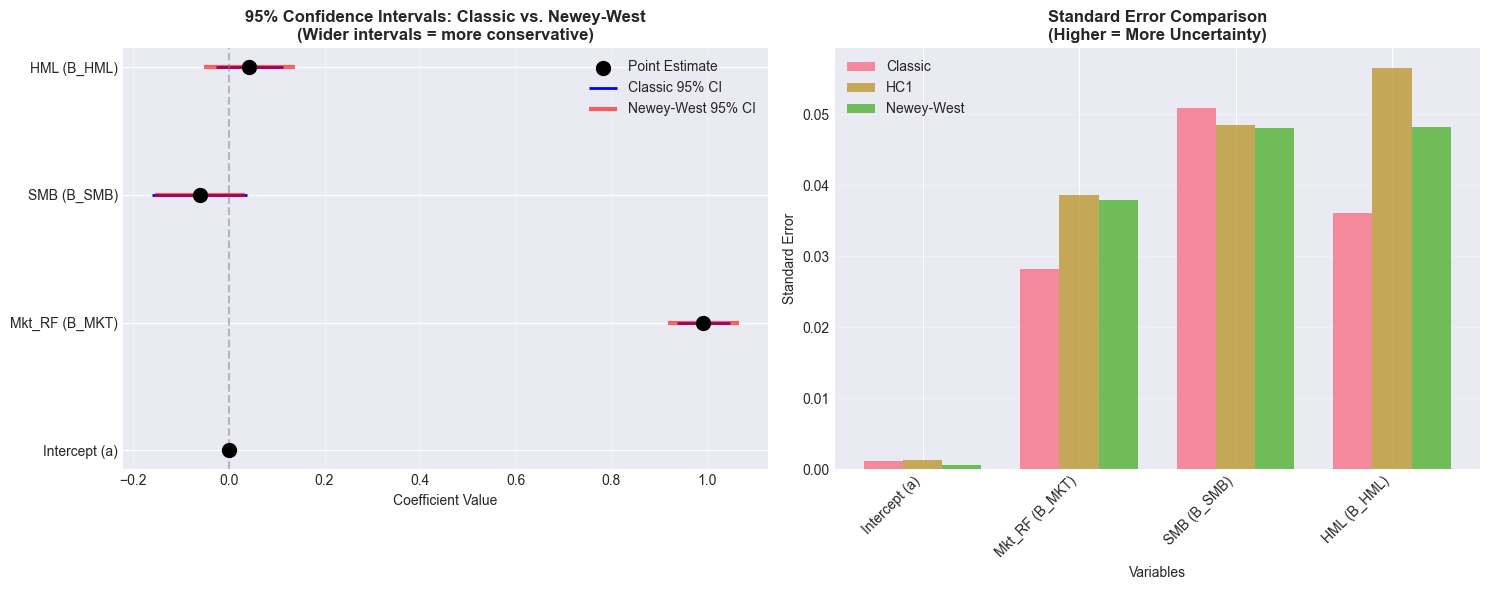


Visualization saved: Confidence interval and standard error comparison


In [16]:
# Visualize the impact on inference: how p-values change
print("\n" + "="*80)
print("IMPACT ON HYPOTHESIS TESTING: HOW P-VALUES CHANGE")
print("="*80)

coefficients = np.asarray(results.params)

# Classic method
classic_pvalues = np.asarray(results.pvalues)

# Robust methods
hc1_tstats = coefficients / hc1_se
hc1_pvalues = 2 * (1 - stats.t.cdf(np.abs(hc1_tstats), n_obs - 4))

nw_tstats = coefficients / nw_se
nw_pvalues = 2 * (1 - stats.t.cdf(np.abs(nw_tstats), n_obs - 4))

print("\nP-value Comparison (Two-tailed test, a = 0.05)")
print("-" * 80)

pvalue_data = {
    'Variable': var_names,
    'Coefficient': coefficients,
    'Classic p-val': classic_pvalues,
    'HC1 p-val': hc1_pvalues,
    'Newey-West p-val': nw_pvalues,
    'Significance Change?': []
}

for i in range(len(var_names)):
    classic_sig = "Yes" if classic_pvalues[i] < 0.05 else "No"
    nw_sig = "Yes" if nw_pvalues[i] < 0.05 else "No"
    change = "YES!" if classic_sig != nw_sig else ""
    pvalue_data['Significance Change?'].append(change)

pvalue_df = pd.DataFrame(pvalue_data)
print(pvalue_df.to_string(index=False))

print("""
CRITICAL: If a variable is significant under classic but NOT under robust SEs
(or vice versa), using the classic method could lead to wrong conclusions!
""")

# Create visualization comparing confidence intervals
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Left plot: Coefficient estimates with different confidence intervals
ax = axes[0]
y_pos = np.arange(len(var_names))

# Classic 95% CI
classic_ci_lower = coefficients - 1.96 * classic_se
classic_ci_upper = coefficients + 1.96 * classic_se

# Newey-West 95% CI
nw_ci_lower = coefficients - 1.96 * nw_se
nw_ci_upper = coefficients + 1.96 * nw_se

ax.scatter(coefficients, y_pos, s=100, color='black', zorder=3, label='Point Estimate')
ax.hlines(y_pos, classic_ci_lower, classic_ci_upper, colors='blue', linewidth=2, label='Classic 95% CI')
ax.hlines(y_pos, nw_ci_lower, nw_ci_upper, colors='red', linewidth=3, alpha=0.6, label='Newey-West 95% CI')
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.5)
ax.set_yticks(y_pos)
ax.set_yticklabels(var_names)
ax.set_xlabel('Coefficient Value')
ax.set_title('95% Confidence Intervals: Classic vs. Newey-West\n(Wider intervals = more conservative)', 
             fontweight='bold', fontsize=12)
ax.legend(loc='best')
ax.grid(True, alpha=0.3, axis='x')

# Right plot: Standard error comparison
ax = axes[1]
x_pos = np.arange(len(var_names))
width = 0.25

ax.bar(x_pos - width, classic_se, width, label='Classic', alpha=0.8)
ax.bar(x_pos, hc1_se, width, label='HC1', alpha=0.8)
ax.bar(x_pos + width, nw_se, width, label='Newey-West', alpha=0.8)

ax.set_xlabel('Variables')
ax.set_ylabel('Standard Error')
ax.set_title('Standard Error Comparison\n(Higher = More Uncertainty)', fontweight='bold', fontsize=12)
ax.set_xticks(x_pos)
ax.set_xticklabels(var_names, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('robust_se_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("\nVisualization saved: Confidence interval and standard error comparison")

In [17]:
# Demonstrate the RECOMMENDED approach: Newey-West for Fama-French analysis

print("="*80)
print("RECOMMENDED APPROACH: FAMA-FRENCH 3-FACTOR WITH NEWEY-WEST SEs")
print("="*80)

print(f"\nOur data: Monthly ETF returns (time-series)")
print(f"Sample: {df.index[0].strftime('%B %Y')} to {df.index[-1].strftime('%B %Y')}")
print(f"Number of observations: {len(df)}")

# Fit with Newey-West standard errors
lag_length = int(np.floor(4 * (len(df) / 100) ** (2/9)))
results_recommended = results.get_robustcov_results(cov_type='HAC', maxlags=lag_length)

print(f"\nNewey-West lag length (Andrews formula): {lag_length}")
print("\nFull Results with Newey-West HAC Standard Errors:")
print("="*80)
print(results_recommended.summary())

print(f"""
WHY THE NEWEY-WEST APPROACH IS BETTER
{'='*80}

Comparison of Standard Errors:
                  Classic SE    Newey-West SE    Difference
Alpha:            {results.bse[0]:11.6f}    {results_recommended.bse[0]:15.6f}    {((results_recommended.bse[0]-results.bse[0])/results.bse[0]*100):+6.1f}%
Beta_MKT:         {results.bse[1]:11.6f}    {results_recommended.bse[1]:15.6f}    {((results_recommended.bse[1]-results.bse[1])/results.bse[1]*100):+6.1f}%
Beta_SMB:         {results.bse[2]:11.6f}    {results_recommended.bse[2]:15.6f}    {((results_recommended.bse[2]-results.bse[2])/results.bse[2]*100):+6.1f}%
Beta_HML:         {results.bse[3]:11.6f}    {results_recommended.bse[3]:15.6f}    {((results_recommended.bse[3]-results.bse[3])/results.bse[3]*100):+6.1f}%

Key Benefits of Newey-West:

1. ACCOUNTS FOR AUTOCORRELATION
   - Monthly returns are not independent
   - Using classic SEs underestimates true uncertainty

2. ACCOUNTS FOR HETEROSCEDASTICITY  
   - Asset volatility varies over time
   - Classic SEs assume constant variance
   
3. MAKES INFERENCE MORE CONSERVATIVE
   - Wider confidence intervals = more honest about uncertainty
   - Lower risk of Type I error (false positives)

4. STANDARD IN FINANCE RESEARCH
   - Published papers use robust SEs
   - Reviewers expect robust standard errors
""")

print("="*80)
print("Now that we have reliable standard errors, we can properly")
print("interpret the coefficients and their significance (next section).")
print()
print("Quick guide — how to read the Newey-West output above:")
print("  • |t| > 2  and  p < 0.05  →  coefficient is statistically significant")
print("  • β_MKT > 1 → more volatile than the market; < 1 → more defensive")
print("  • β_SMB > 0 → tilts toward small caps; < 0 → tilts toward large caps")
print("  • β_HML > 0 → tilts toward value; < 0 → tilts toward growth")
print("  • α ≈ 0 and not significant → no abnormal return beyond factor exposure")
print("="*80)

RECOMMENDED APPROACH: FAMA-FRENCH 3-FACTOR WITH NEWEY-WEST SEs

Our data: Monthly ETF returns (time-series)
Sample: January 2010 to November 2023
Number of observations: 167

Newey-West lag length (Andrews formula): 4

Full Results with Newey-West HAC Standard Errors:
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     307.3
Date:                Sun, 01 Mar 2026   Prob (F-statistic):           7.63e-67
Time:                        08:59:38   Log-Likelihood:                 464.00
No. Observations:                 167   AIC:                            -920.0
Df Residuals:                     163   BIC:                            -907.5
Df Model:                           3                                         
Covariance Type:    

---

## Section 10: Interpreting the Results — t-Statistics, p-Values, and Confidence Intervals

Now that we have **reliable standard errors** (Newey-West), we can properly interpret each coefficient and its statistical significance.

> **Why can we use the normal distribution for p-values here?** The CLT guarantees that OLS coefficients are approximately normally distributed for large $n$, **regardless of the error distribution**. Combined with Newey-West and Slutsky's theorem, the t-statistic converges to $\mathcal{N}(0,1)$. For the full five-step argument, see the [Statistical Foundations Tutorial](01_Statistical_Foundations.ipynb), Section 9.

### Quick Refresher (detailed derivations: [Statistical Foundations](01_Statistical_Foundations.ipynb), Section 4)

| Statistic | Formula | Rule of thumb |
|-----------|---------|---------------|
| **t-statistic** | $t = \hat{\beta}_j \,/\, \text{SE}(\hat{\beta}_j)$ | $|t| > 2$ → significant |
| **p-value** | Prob of result this extreme under $H_0:\beta_j=0$ | $p < 0.05$ → reject $H_0$ |
| **95 % CI** | $\hat{\beta}_j \pm 1.96 \times \text{SE}(\hat{\beta}_j)$ | CI excludes 0 → significant |

**Statistical vs economic significance:** A tiny but precisely estimated effect can be statistically significant (small $p$) without being economically meaningful. For example, $\hat\alpha = 0.0002$ (0.02 %/month ≈ 0.24 %/year) may matter statistically but is smaller than most transaction costs. Always ask: *Is the magnitude large enough to matter in practice?*

### Interpreting the Fama-French Coefficients

| Coefficient | What it measures | Positive means | Negative means |
|-------------|-----------------|----------------|----------------|
| $\alpha$ (Jensen's Alpha) | Abnormal return beyond factor exposure | Outperformance | Underperformance |
| $\beta_{MKT}$ | Market sensitivity | Aggressive ($>1$) | Defensive ($<1$) |
| $\beta_{SMB}$ | Size tilt | Small-cap tilt | Large-cap tilt |
| $\beta_{HML}$ | Value tilt | Value tilt | Growth tilt |

### Let's Now Interpret Our Fama-French Results Using Newey-West Standard Errors

In [18]:
# Interpret each coefficient using Newey-West robust standard errors
print("="*70)
print("DETAILED INTERPRETATION OF COEFFICIENTS (NEWEY-WEST SEs)")
print("="*70)

coef_nw = results_recommended.params
se_nw = results_recommended.bse
pval_nw = results_recommended.pvalues
ci_nw = results_recommended.conf_int()

# Extract each coefficient
alpha = coef_nw[0]
beta_mkt = coef_nw[1]
beta_smb = coef_nw[2]
beta_hml = coef_nw[3]

print(f"\n1. ALPHA (Jensen's Alpha)")
print(f"   Estimate: {alpha:.6f} ({alpha*100:.4f}% per month)")
print(f"   Newey-West Std Error: {se_nw[0]:.6f}")
print(f"   t-statistic: {alpha/se_nw[0]:.4f}")
print(f"   p-value: {pval_nw[0]:.4f}")
print(f"   95% CI: [{ci_nw[0, 0]:.6f}, {ci_nw[0, 1]:.6f}]")
print(f"   Interpretation: This is Jensen's alpha. It represents the abnormal")
print(f"   monthly return not explained by the three factors. A value of {alpha:.4f}")
print(f"   ({alpha*100:.2f}% per month) means this ETF earns an excess return of")
print(f"   {alpha*100:.2f}% per month beyond what the model predicts.")
if pval_nw[0] < 0.05:
    print(f"   STATISTICALLY SIGNIFICANT (p < 0.05): The ETF appears to have abnormal alpha.")
else:
    print(f"   NOT statistically significant (p >= 0.05): Cannot distinguish alpha from zero.")

print(f"\n2. BETA_MKT (Market Beta)")
print(f"   Estimate: {beta_mkt:.6f}")
print(f"   Newey-West Std Error: {se_nw[1]:.6f}")
print(f"   t-statistic: {beta_mkt/se_nw[1]:.4f}")
print(f"   p-value: {pval_nw[1]:.4f}")
print(f"   95% CI: [{ci_nw[1, 0]:.6f}, {ci_nw[1, 1]:.6f}]")
print(f"   Interpretation: For every 1% increase in the market excess return,")
print(f"   the ETF's excess return changes by {beta_mkt:.4f}% (holding other")
print(f"   factors constant). A value > 1 means the ETF is MORE volatile than")
print(f"   the market; < 1 means LESS volatile (more defensive).")
if pval_nw[1] < 0.05:
    print(f"   STATISTICALLY SIGNIFICANT: Market exposure is real.")
else:
    print(f"   NOT statistically significant.")

print(f"\n3. BETA_SMB (Size Factor)")
print(f"   Estimate: {beta_smb:.6f}")
print(f"   Newey-West Std Error: {se_nw[2]:.6f}")
print(f"   t-statistic: {beta_smb/se_nw[2]:.4f}")
print(f"   p-value: {pval_nw[2]:.4f}")
print(f"   95% CI: [{ci_nw[2, 0]:.6f}, {ci_nw[2, 1]:.6f}]")
print(f"   Interpretation: For every 1% increase in the SMB factor (small")
print(f"   relative to big), the ETF's excess return changes by {beta_smb:.4f}%.")
print(f"   A positive value means the ETF tilts toward SMALL-cap exposure.")
print(f"   A negative value would mean it tilts toward LARGE-cap exposure.")
if pval_nw[2] < 0.05:
    print(f"   STATISTICALLY SIGNIFICANT: Real size effect exposure.")
else:
    print(f"   NOT statistically significant: Size effect not clearly present.")

print(f"\n4. BETA_HML (Value Factor)")
print(f"   Estimate: {beta_hml:.6f}")
print(f"   Newey-West Std Error: {se_nw[3]:.6f}")
print(f"   t-statistic: {beta_hml/se_nw[3]:.4f}")
print(f"   p-value: {pval_nw[3]:.4f}")
print(f"   95% CI: [{ci_nw[3, 0]:.6f}, {ci_nw[3, 1]:.6f}]")
print(f"   Interpretation: For every 1% increase in the HML factor (value")
print(f"   relative to growth), the ETF's excess return changes by {beta_hml:.4f}%.")
print(f"   A positive value means the ETF tilts toward VALUE exposure.")
print(f"   A negative value would mean it tilts toward GROWTH exposure.")
if pval_nw[3] < 0.05:
    print(f"   STATISTICALLY SIGNIFICANT: Real value effect exposure.")
else:
    print(f"   NOT statistically significant: Value effect not clearly present.")

print("\n" + "="*70)
print("KEY TAKEAWAY")
print("="*70)
print("""
All the standard errors, t-statistics, p-values, and confidence intervals
above use Newey-West HAC estimation. This means:

- They account for heteroscedasticity (time-varying volatility)
- They account for autocorrelation (serial dependence in returns)
- The conclusions are MORE RELIABLE than using classic OLS standard errors

When reporting Fama-French results:
  - Always use Newey-West HAC standard errors for time-series data
  - Report the lag length used (here: Andrews formula)
  - Discuss economic significance separately from statistical significance
  - Compare with classic SEs as a robustness check
""")

DETAILED INTERPRETATION OF COEFFICIENTS (NEWEY-WEST SEs)

1. ALPHA (Jensen's Alpha)
   Estimate: 0.000158 (0.0158% per month)
   Newey-West Std Error: 0.000680
   t-statistic: 0.2332
   p-value: 0.8159
   95% CI: [-0.001183, 0.001500]
   Interpretation: This is Jensen's alpha. It represents the abnormal
   monthly return not explained by the three factors. A value of 0.0002
   (0.02% per month) means this ETF earns an excess return of
   0.02% per month beyond what the model predicts.
   NOT statistically significant (p >= 0.05): Cannot distinguish alpha from zero.

2. BETA_MKT (Market Beta)
   Estimate: 0.992104
   Newey-West Std Error: 0.037957
   t-statistic: 26.1373
   p-value: 0.0000
   95% CI: [0.917153, 1.067056]
   Interpretation: For every 1% increase in the market excess return,
   the ETF's excess return changes by 0.9921% (holding other
   factors constant). A value > 1 means the ETF is MORE volatile than
   the market; < 1 means LESS volatile (more defensive).
   STATISTIC

---

## Section 11: Complete Worked Example - Using the Model to Make Predictions

Now let's use our fitted model to make a prediction and see how the model works in practice.

### The Prediction Formula

For any month with known factor values, we can predict the ETF's excess return using:

$$\hat{R}_i = \hat{\alpha} + \hat{\beta}_{MKT} \cdot (R_m - R_f) + \hat{\beta}_{SMB} \cdot SMB + \hat{\beta}_{HML} \cdot HML$$

Let's make a prediction for a specific month and compare it to the actual return.

In [19]:
print("="*70)
print("WORKED EXAMPLE: PREDICTING ETF RETURN FOR A SPECIFIC MONTH")
print("="*70)

# Let's use the first month in our data
month_idx = 50  # Choose a month in the middle of data
date = df.index[month_idx]

# Get the actual values for this month
mkt_rf_actual = df['Mkt_RF'].iloc[month_idx]
smb_actual = df['SMB'].iloc[month_idx]
hml_actual = df['HML'].iloc[month_idx]
stock_return_actual = df['Stock_Excess_Return'].iloc[month_idx]

print(f"\nDate: {date.strftime('%B %Y')}")
print(f"\nFactor values for this month:")
print(f"  Market Risk Premium (Mkt_RF): {mkt_rf_actual:.4f} ({mkt_rf_actual*100:.2f}%)")
print(f"  SMB Factor:                    {smb_actual:.4f} ({smb_actual*100:.2f}%)")
print(f"  HML Factor:                    {hml_actual:.4f} ({hml_actual*100:.2f}%)")

# Get our estimated coefficients
alpha_hat = results.params[0]
beta_mkt_hat = results.params[1]
beta_smb_hat = results.params[2]
beta_hml_hat = results.params[3]

print(f"\nOur estimated model coefficients:")
print(f"  α̂ (Alpha):     {alpha_hat:.6f}")
print(f"  β̂_MKT:         {beta_mkt_hat:.6f}")
print(f"  β̂_SMB:         {beta_smb_hat:.6f}")
print(f"  β̂_HML:         {beta_hml_hat:.6f}")

# Make the prediction manually showing all steps
print(f"\n" + "="*70)
print("PREDICTION CALCULATION (STEP BY STEP)")
print("="*70)

print(f"\nFormula: R̂_i = α̂ + β̂_MKT × Mkt_RF + β̂_SMB × SMB + β̂_HML × HML")
print(f"\nR̂_i = {alpha_hat:.6f}")
print(f"     + {beta_mkt_hat:.6f} × {mkt_rf_actual:.6f}")
print(f"     + {beta_smb_hat:.6f} × {smb_actual:.6f}")
print(f"     + {beta_hml_hat:.6f} × {hml_actual:.6f}")

# Calculate each component
component_alpha = alpha_hat
component_mkt = beta_mkt_hat * mkt_rf_actual
component_smb = beta_smb_hat * smb_actual
component_hml = beta_hml_hat * hml_actual

print(f"\nComponent breakdown:")
print(f"  α̂:                    {component_alpha:.6f} ({component_alpha*100:.4f}%)")
print(f"  β̂_MKT × Mkt_RF:       {component_mkt:.6f} ({component_mkt*100:.4f}%)")
print(f"  β̂_SMB × SMB:          {component_smb:.6f} ({component_smb*100:.4f}%)")
print(f"  β̂_HML × HML:          {component_hml:.6f} ({component_hml*100:.4f}%)")

# Total prediction
stock_return_pred = component_alpha + component_mkt + component_smb + component_hml

print(f"\nPredicted return (sum): {stock_return_pred:.6f} ({stock_return_pred*100:.4f}%)")
print(f"Actual return:          {stock_return_actual:.6f} ({stock_return_actual*100:.4f}%)")

# Calculate prediction error (residual)
residual = stock_return_actual - stock_return_pred
print(f"\nPrediction error (residual): {residual:.6f} ({residual*100:.4f}%)")
print(f"\nInterpretation:")
if abs(residual) < 0.01:
    print(f"  The model predicted very accurately for this month!")
elif residual > 0:
    print(f"  The ETF OUTPERFORMED the model's prediction by {abs(residual)*100:.4f}%")
    print(f"  This positive residual means the ETF did better than expected")
    print(f"  given its exposure to the three factors.")
else:
    print(f"  The ETF UNDERPERFORMED the model's prediction by {abs(residual)*100:.4f}%")
    print(f"  This negative residual means the ETF did worse than expected")
    print(f"  given its exposure to the three factors.")

# Verify using statsmodels
pred_check = results.fittedvalues[month_idx]
pred_error_check = results.resid[month_idx]
print(f"\nVerification with statsmodels:")
print(f"  Fitted value from statsmodels:  {pred_check:.6f}")
print(f"  Residual from statsmodels:      {pred_error_check:.6f}")
print(f"  Match? {np.isclose(stock_return_pred, pred_check) and np.isclose(residual, pred_error_check)}")


WORKED EXAMPLE: PREDICTING ETF RETURN FOR A SPECIFIC MONTH

Date: March 2014

Factor values for this month:
  Market Risk Premium (Mkt_RF): 0.0043 (0.43%)
  SMB Factor:                    -0.0186 (-1.86%)
  HML Factor:                    0.0490 (4.90%)

Our estimated model coefficients:
  α̂ (Alpha):     0.000158
  β̂_MKT:         0.992104
  β̂_SMB:         -0.061203
  β̂_HML:         0.042830

PREDICTION CALCULATION (STEP BY STEP)

Formula: R̂_i = α̂ + β̂_MKT × Mkt_RF + β̂_SMB × SMB + β̂_HML × HML

R̂_i = 0.000158
     + 0.992104 × 0.004300
     + -0.061203 × -0.018600
     + 0.042830 × 0.049000

Component breakdown:
  α̂:                    0.000158 (0.0158%)
  β̂_MKT × Mkt_RF:       0.004266 (0.4266%)
  β̂_SMB × SMB:          0.001138 (0.1138%)
  β̂_HML × HML:          0.002099 (0.2099%)

Predicted return (sum): 0.007662 (0.7662%)
Actual return:          0.022169 (2.2169%)

Prediction error (residual): 0.014508 (1.4508%)

Interpretation:
  The ETF OUTPERFORMED the model's prediction

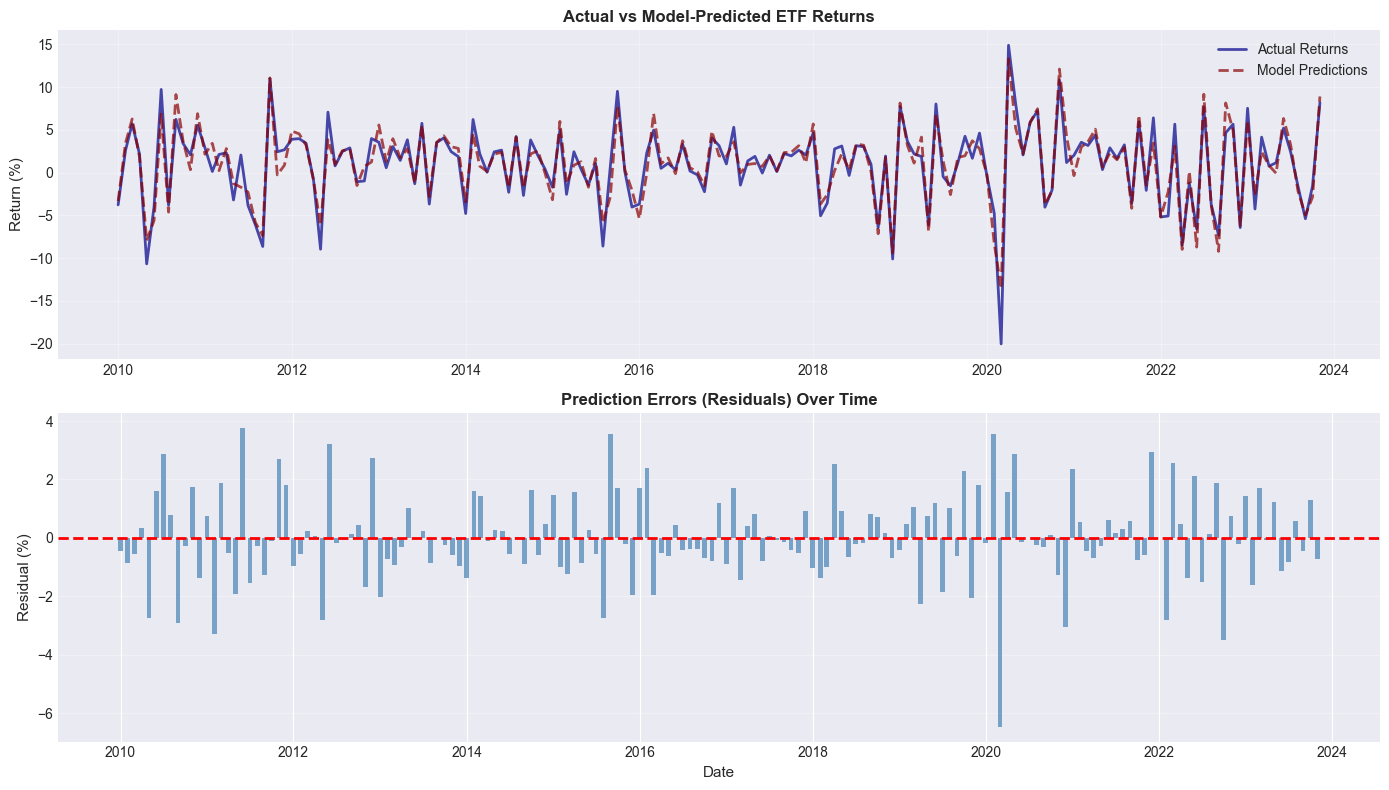

Prediction visualization created.


In [20]:
# Visualize predictions vs actual returns
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Plot 1: Actual vs Predicted
axes[0].plot(df.index, df['Stock_Excess_Return']*100, label='Actual Returns', 
             linewidth=2, alpha=0.7, color='darkblue')
axes[0].plot(df.index, results.fittedvalues*100, label='Model Predictions', 
             linewidth=2, alpha=0.7, color='darkred', linestyle='--')
axes[0].set_ylabel('Return (%)', fontsize=11)
axes[0].set_title('Actual vs Model-Predicted ETF Returns', fontsize=12, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals (prediction errors)
axes[1].bar(df.index, results.resid*100, alpha=0.7, color='steelblue', width=20)
axes[1].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[1].set_ylabel('Residual (%)', fontsize=11)
axes[1].set_xlabel('Date', fontsize=11)
axes[1].set_title('Prediction Errors (Residuals) Over Time', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fama_french_predictions.png', dpi=100, bbox_inches='tight')
plt.show()

print("Prediction visualization created.")

---

## Section 12: Complete Summary and Key Takeaways

### What We Learned

In this comprehensive tutorial, we covered:

1. **The Fama-French Model Concept** (Sections 1-2): A framework to explain stock returns using three factors — market risk premium, size effect (SMB), and value effect (HML)

2. **Linear Regression Mathematics** (Sections 4-5): Setting up the design matrix, the normal equations, and the OLS formula to obtain coefficient estimates

3. **Model Evaluation** (Section 7): $R^2$ and adjusted $R^2$ to measure fit, residual standard error, and F-statistics to test overall model significance

4. **Diagnostic Testing** (Section 8): Checking regression assumptions through visual diagnostics and formal tests (Jarque-Bera, Breusch-Pagan, Durbin-Watson, VIF)

5. **Robust Inference** (Section 9): Why classic standard errors can be misleading for financial time-series, and how Newey-West HAC standard errors provide reliable inference

6. **Statistical Interpretation** (Section 10): How to properly interpret t-statistics, p-values, and confidence intervals using robust standard errors — the approach used in published finance research

7. **Practical Application** (Section 11): Making predictions using the fitted model and understanding the decomposition of returns

### Key Formulas Summary

| Concept | Formula |
|---------|---------|
| **Model Equation** | $R_i - R_f = \alpha + \beta_{MKT}(R_m - R_f) + \beta_{SMB} \cdot SMB + \beta_{HML} \cdot HML + \epsilon$ |
| **OLS Estimator** | $\hat{\boldsymbol{\beta}} = (\mathbf{X}^T \mathbf{X})^{-1} \mathbf{X}^T \mathbf{y}$ |
| **R-squared** | $R^2 = 1 - \frac{RSS}{TSS}$ |
| **Adjusted R-squared** | $\bar{R}^2 = 1 - \frac{(1-R^2)(n-1)}{n-k}$ |
| **t-statistic** | $t = \frac{\hat{\beta}_j}{\text{SE}(\hat{\beta}_j)}$ |
| **Newey-West Var** | $\hat{\text{Var}}_{NW}(\hat{\boldsymbol{\beta}}) = (\mathbf{X}^T \mathbf{X})^{-1} \left[ \sum_{j=0}^{M} w_j \mathbf{X}^T \boldsymbol{\Omega}_j \mathbf{X} \right] (\mathbf{X}^T \mathbf{X})^{-1}$ |

### Interpreting Your Results

When you fit a Fama-French model to real data:

1. **Check the R-squared**: A higher $R^2$ means the three factors explain more of the asset's returns
   - $R^2 < 0.3$: Factors don't explain much variation
   - $0.3 < R^2 < 0.6$: Factors explain moderate variation
   - $R^2 > 0.6$: Factors explain substantial variation

2. **Use robust standard errors**: Always use Newey-West HAC for time-series regressions. Report the lag length and note the method.

3. **Examine the Alpha**: 
   - Positive, significant alpha: Asset outperforms (alpha-generating ability)
   - Negative, significant alpha: Asset underperforms
   - Insignificant alpha: Can't distinguish from luck

4. **Look at the Betas**:
   - $\beta_{MKT}$: Is the asset aggressive ($>1$) or defensive ($<1$)?
   - $\beta_{SMB}$: Does it tilt toward small caps ($>0$) or large caps ($<0$)?
   - $\beta_{HML}$: Does it tilt toward value ($>0$) or growth ($<0$)?

5. **Distinguish statistical from economic significance**: A tiny but precisely estimated effect might be statistically significant without being economically meaningful.

### Common Extensions

Once you understand this framework, you can extend it:

1. **Add more factors**: The Fama-French 5-factor model adds profitability and investment factors
2. **Time-varying betas**: Allow coefficients to change over time using rolling windows
3. **Alternative specifications**: Use different factor definitions or construct your own factors
4. **Cross-sectional analysis**: Analyze many stocks simultaneously
5. **Robustness checks**: Use different time periods, rolling windows, or subsamples

### Final Thoughts

The Fama-French model is not just a statistical exercise — it's a tool for understanding investment risk and return. By decomposing returns into factor exposures, investors can:
- Understand what they're really betting on
- Manage risk more intentionally
- Evaluate manager performance fairly
- Construct portfolios aligned with their views

The regression analysis skills you've learned here extend far beyond finance — they apply to any field where you need to understand relationships in data.

---

## Appendix: Useful Resources and Reference Code

### Getting Real Fama-French Data

In this tutorial we downloaded factors directly from Kenneth French's website. Here are alternative approaches:

```python
# Option 1: Direct download (used in this notebook)
import urllib.request, zipfile, tempfile, pandas as pd
url = 'https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_Factors_CSV.zip'

# Option 2: Use pandas_datareader library (requires: pip install pandas-datareader)
from pandas_datareader import data as web
ff_factors = web.DataReader('F-F_Research_Data_Factors', 'famafrench',
                            start='2010-01-01', end='2023-12-31')

# Option 3: Use yfinance for ETF/stock returns
import yfinance as yf
etf = yf.download('SPY', start='2010-01-01', end='2023-12-31')
```

### Alternative Factor Sets

Kenneth French also publishes regional and global factor data:
- **Global Factors**: `F-F_Research_Data_Factors` -> replace with `Global_3_Factors`
- **European Factors**: `Europe_3_Factors`
- **Developed Markets**: `Developed_3_Factors`

Using region-matched factors (e.g., European factors for European ETFs) can improve model fit for non-US assets.

### Quick Reference: Key Statistical Concepts

**p-value**: Probability of observing this result by chance if null hypothesis is true
- $p < 0.01$: **Highly significant** (strong evidence)
- $0.01 < p < 0.05$: **Significant** (moderate evidence)
- $0.05 < p < 0.10$: **Marginally significant** (weak evidence)
- $p > 0.10$: **Not significant** (insufficient evidence)

**Confidence Interval**: Range where we're confident (usually 95%) the true value lies
- If CI contains 0: Coefficient might not be significantly different from zero

**Standard Error**: Measure of uncertainty in the estimate
- Smaller SE = More precise estimate
- Larger SE = More uncertainty

### Troubleshooting Common Issues

| Problem | Likely Cause | Solution |
|---------|-------------|----------|
| Very low $R^2$ | Missing important factors | Add more relevant variables |
| High p-values for all betas | Multicollinearity | Check VIF, remove correlated variables |
| Non-normal residuals | Outliers or wrong model | Check for outliers, try robust regression |
| Heteroscedasticity | Unequal error variance | Use robust standard errors |
| Autocorrelation | Time-series pattern | Use time-series methods, transform data |

### Quick Regression Summary Template

For any regression analysis, report:
1. **The model**: What's the dependent and independent variables?
2. **Sample**: How many observations? What time period?
3. **Coefficients**: What are the estimates and are they significant?
4. **Fit quality**: What's the $R^2$? Do assumptions hold?
5. **Economic significance**: Are the effects meaningful in practice?
6. **Robustness**: Did you check sensitivity to different specifications?

In [21]:
# ============================================================================
# REUSABLE FAMA-FRENCH ANALYSIS TEMPLATE
# ============================================================================
# Use this template as a starting point for analyzing your own stock/portfolio
# ============================================================================

def fama_french_analysis(stock_excess_returns, mkt_rf, smb, hml, stock_name="Stock", use_robust_se=True):
    """
    Complete Fama-French 3-factor analysis in one function.
    
    Parameters:
    -----------
    stock_excess_returns : array-like
        Excess returns of the stock/portfolio (length n)
    mkt_rf : array-like
        Market risk premium (length n)
    smb : array-like
        SMB factor returns (length n)
    hml : array-like
        HML factor returns (length n)
    stock_name : str
        Name of the stock for display purposes
    use_robust_se : bool
        If True, use Newey-West HAC standard errors (recommended for time-series)
        If False, use classic OLS standard errors
        
    Returns:
    --------
    results : OLS regression results object (always the same type)
    """
    
    print("="*70)
    print(f"FAMA-FRENCH 3-FACTOR ANALYSIS: {stock_name}")
    print("="*70)
    
    # Prepare data
    y = np.array(stock_excess_returns)
    X = np.column_stack([mkt_rf, smb, hml])
    X = sm.add_constant(X)
    
    # Fit model
    model = sm.OLS(y, X)
    r = model.fit()
    
    # Apply robust standard errors if requested
    if use_robust_se:
        n_obs = len(y)
        lag_length = int(np.floor(4 * (n_obs / 100) ** (2/9)))
        r = r.get_robustcov_results(cov_type='HAC', maxlags=lag_length)
        se_type = f"Newey-West HAC (lags={lag_length})"
    else:
        se_type = "Classic OLS"
    
    # Print summary
    print(f"\nUsing {se_type} standard errors\n")
    print(r.summary())
    
    # Extract key statistics
    print("\n" + "="*70)
    print("KEY FINDINGS")
    print("="*70)
    
    alpha, beta_mkt, beta_smb, beta_hml = r.params
    p_vals = r.pvalues
    
    print(f"\nalpha:     {alpha:9.6f}  p-value: {p_vals[0]:.4f}  {'***' if p_vals[0] < 0.01 else ('**' if p_vals[0] < 0.05 else '')}")
    print(f"beta_mkt:  {beta_mkt:9.6f}  p-value: {p_vals[1]:.4f}  {'***' if p_vals[1] < 0.01 else ('**' if p_vals[1] < 0.05 else '')}")
    print(f"beta_smb:  {beta_smb:9.6f}  p-value: {p_vals[2]:.4f}  {'***' if p_vals[2] < 0.01 else ('**' if p_vals[2] < 0.05 else '')}")
    print(f"beta_hml:  {beta_hml:9.6f}  p-value: {p_vals[3]:.4f}  {'***' if p_vals[3] < 0.01 else ('**' if p_vals[3] < 0.05 else '')}")
    
    print(f"\nR-squared: {r.rsquared:.6f}")
    print(f"Adj R-squared: {r.rsquared_adj:.6f}")
    print(f"F-statistic: {r.fvalue:.4f} (p < {r.f_pvalue:.2e})")
    
    print("\nNote: *** p<0.01, ** p<0.05, * p<0.10")
    
    return r

# ============================================================================
# COMPARISON OF ALL THREE ETFs
# ============================================================================
print("\n" + "#"*70)
print("# COMPARING FACTOR EXPOSURES: SPY vs. IWN vs. VTV")
print("#"*70)
print()
print("We now run the same Fama-French regression on all three ETFs and")
print("compare their factor loadings. This reveals how each investment")
print("style maps onto the market, size, and value dimensions.\n")

all_results = {}
for ticker, label in etf_tickers.items():
    edf = etf_dataframes[ticker]
    res = fama_french_analysis(
        edf['Stock_Excess_Return'].values,
        edf['Mkt_RF'].values,
        edf['SMB'].values,
        edf['HML'].values,
        stock_name=label,
        use_robust_se=True
    )
    all_results[ticker] = res
    print("\n")

# Summary comparison table
print("="*70)
print("SIDE-BY-SIDE FACTOR LOADING COMPARISON")
print("="*70)

header = f"{'':20s}  {'SPY':>10s}  {'IWN':>10s}  {'VTV':>10s}"
print(header)
print("-" * len(header))

labels_short = list(etf_tickers.keys())
row_names = ['Alpha (a)', 'Beta MKT', 'Beta SMB', 'Beta HML', 'R-squared', 'Adj R-squared']

for i, name in enumerate(row_names):
    vals = []
    for t in labels_short:
        r = all_results[t]
        if i < 4:
            vals.append(f"{r.params[i]:10.4f}")
        elif i == 4:
            vals.append(f"{r.rsquared:10.4f}")
        else:
            vals.append(f"{r.rsquared_adj:10.4f}")
    print(f"{name:20s}  {'  '.join(vals)}")

# Significance markers
print()
for i, name in enumerate(['Alpha', 'Beta MKT', 'Beta SMB', 'Beta HML']):
    sigs = []
    for t in labels_short:
        p = all_results[t].pvalues[i]
        star = '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.10 else ''))
        sigs.append(f"{star:>10s}")
    print(f"{'  p-sig ' + name:20s}  {'  '.join(sigs)}")

print("\n" + "="*70)
print("INTERPRETATION")
print("="*70)
print("""
What to look for in the table above:

- SPY (S&P 500): Should have beta_MKT very close to 1.0, with low/insignificant
  SMB and HML loadings. It IS the market, so the model should explain its
  returns almost entirely through the market factor. Expect high R-squared.

- IWN (Small Cap Value): Should have POSITIVE beta_SMB (small-cap tilt) AND
  POSITIVE beta_HML (value tilt). This ETF explicitly targets small companies
  with high book-to-market ratios -- exactly the stocks that drive the SMB
  and HML factors.

- VTV (Large Cap Value): Should have near-zero or NEGATIVE beta_SMB (large-cap)
  and POSITIVE beta_HML (value tilt). This isolates the value effect from
  the size effect, showing that HML captures something distinct from SMB.
""")


######################################################################
# COMPARING FACTOR EXPOSURES: SPY vs. IWN vs. VTV
######################################################################

We now run the same Fama-French regression on all three ETFs and
compare their factor loadings. This reveals how each investment
style maps onto the market, size, and value dimensions.

FAMA-FRENCH 3-FACTOR ANALYSIS: SPY (S&P 500)

Using Newey-West HAC (lags=4) standard errors

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     307.3
Date:                Sun, 01 Mar 2026   Prob (F-statistic):           7.63e-67
Time:                        08:59:57   Log-Likelihood:                 464.00
No. Observations:                 167   AIC:         

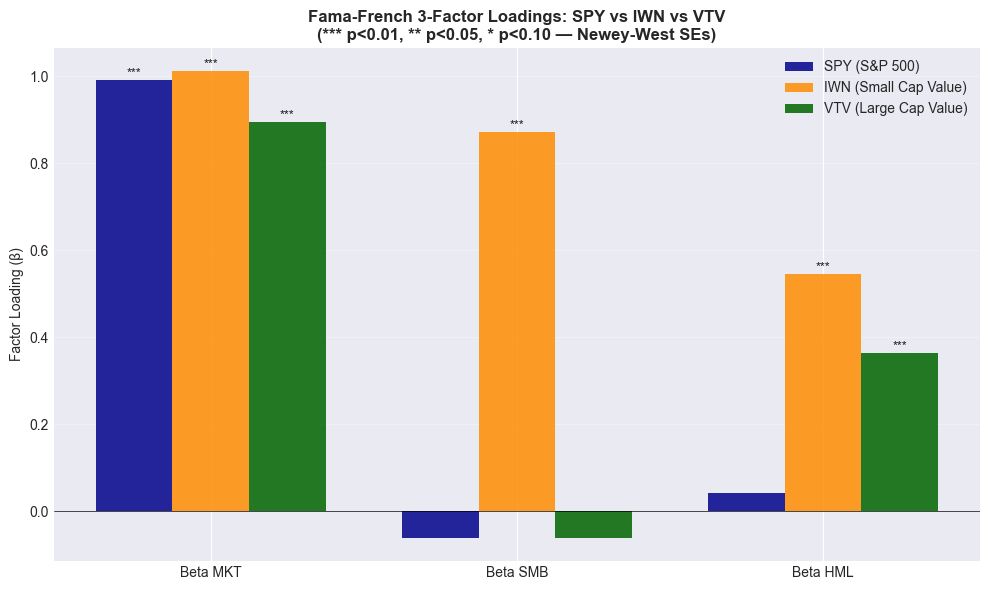


This chart makes the factor exposures immediately visible:
- SPY: Dominated by market beta (~1.0), with minimal size or value tilts
- IWN: Positive loadings on ALL three factors, especially SMB and HML
- VTV: Strong market and value exposure, but low/negative size exposure



In [22]:
# ============================================================================
# VISUALIZE FACTOR LOADINGS ACROSS ALL THREE ETFs
# ============================================================================

fig, ax = plt.subplots(figsize=(10, 6))

var_names_bar = ['Beta MKT', 'Beta SMB', 'Beta HML']
x_pos = np.arange(len(var_names_bar))
width = 0.25
colors_bar = {'SPY': 'darkblue', 'IWN': 'darkorange', 'VTV': 'darkgreen'}

for i, (ticker, label) in enumerate(etf_tickers.items()):
    r = all_results[ticker]
    betas = [r.params[1], r.params[2], r.params[3]]  # MKT, SMB, HML
    pvals = [r.pvalues[1], r.pvalues[2], r.pvalues[3]]
    bars = ax.bar(x_pos + i * width, betas, width, label=label,
                  color=colors_bar[ticker], alpha=0.85)
    # Add significance stars
    for j, bar in enumerate(bars):
        p = pvals[j]
        star = '***' if p < 0.01 else ('**' if p < 0.05 else ('*' if p < 0.10 else ''))
        if star:
            ax.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
                    star, ha='center', va='bottom', fontsize=9)

ax.set_xticks(x_pos + width)
ax.set_xticklabels(var_names_bar)
ax.set_ylabel('Factor Loading (β)')
ax.set_title('Fama-French 3-Factor Loadings: SPY vs IWN vs VTV\n'
             '(*** p<0.01, ** p<0.05, * p<0.10 — Newey-West SEs)',
             fontweight='bold', fontsize=12)
ax.axhline(0, color='black', linewidth=0.5)
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('etf_factor_loadings_comparison.png', dpi=100, bbox_inches='tight')
plt.show()

print("""
This chart makes the factor exposures immediately visible:
- SPY: Dominated by market beta (~1.0), with minimal size or value tilts
- IWN: Positive loadings on ALL three factors, especially SMB and HML
- VTV: Strong market and value exposure, but low/negative size exposure
""")

---

## Exercises

Test your understanding by working through these exercises. They range from conceptual questions to hands-on coding tasks.

### Exercise 1: Predicting Factor Loadings (Conceptual)

Before running any code, predict the factor loadings for the following hypothetical ETFs. For each, state whether you expect $\beta_{MKT}$, $\beta_{SMB}$, and $\beta_{HML}$ to be positive, negative, or near zero, and briefly explain why.

1. **QQQ** (Invesco Nasdaq-100 ETF) -- tracks large-cap US technology/growth stocks
2. **IWM** (iShares Russell 2000 ETF) -- tracks US small-cap stocks (no value/growth tilt)
3. **A leveraged 2x S&P 500 ETF**

### Exercise 2: Comparing ETFs (Hands-On)

Using the `fama_french_analysis()` template function defined above:

1. Re-run the analysis for **IWN** (Small Cap Value) only. Is the $R^2$ higher or lower than for SPY? Why might that be?
2. Compare the $\beta_{SMB}$ values between SPY, IWN, and VTV. Do they match your intuition about each fund's size exposure?

*Hint*: The data is already loaded in `etf_dataframes`. You can access it as `etf_dataframes['IWN']`.

### Exercise 3: Sensitivity of Newey-West Standard Errors (Hands-On)

The Newey-West lag length affects the standard errors. Try the following:

1. Re-fit the SPY regression using `maxlags=0` (no autocorrelation correction, only heteroscedasticity). How do the standard errors compare to classic OLS?
2. Re-fit using `maxlags=8` (more lags). How do the standard errors change compared to the default lag length?
3. What does this tell you about the sensitivity of your conclusions to lag choice?

```python
# Starter code for Exercise 3:
model_ex3 = sm.OLS(df['Stock_Excess_Return'].values, sm.add_constant(df[['Mkt_RF', 'SMB', 'HML']].values))
results_ex3 = model_ex3.fit()

# Try different lag lengths:
results_lag0 = results_ex3.get_robustcov_results(cov_type='HAC', maxlags=0)
results_lag8 = results_ex3.get_robustcov_results(cov_type='HAC', maxlags=8)

print("Lag 0 SEs:", results_lag0.bse)
print("Lag 8 SEs:", results_lag8.bse)
```

### Exercise 4: Economic vs. Statistical Significance (Discussion)

Suppose you find that $\hat{\alpha} = 0.0003$ (0.03% per month) with a p-value of 0.04.

1. Is this result statistically significant at the 5% level?
2. Is it economically significant? (Hint: What does 0.03% per month translate to annually? Would an investor change their portfolio based on this?)
3. What might happen to the p-value if you used Newey-West standard errors instead of classic OLS?

### Exercise 5: Extending to Another Asset (Challenge)

Download return data for a stock or ETF of your choice and run the full Fama-French 3-factor analysis:

1. Download the data using `yfinance`
2. Compute monthly excess returns
3. Run the regression with Newey-West standard errors
4. Interpret the coefficients -- what does the asset's factor exposure tell you about its risk characteristics?
5. Check the diagnostic plots -- are the regression assumptions satisfied?

```python
# Starter code for Exercise 5:
# Replace 'AAPL' with any US-listed ticker
import yfinance as yf
my_data = yf.download('AAPL', start='2010-01-01', end='2023-12-31', progress=False)
# ... compute monthly returns, align with ff_factors, and run fama_french_analysis()
```

---

## Conclusion

By working through this tutorial, you've learned:

- **Statistical foundations**: How multiple linear regression works from the ground up  
- **Mathematical derivations**: The normal equations and OLS formula
- **Practical application**: How to fit models and make predictions in Python  
- **Interpretation skills**: How to understand and communicate results
- **Diagnostic expertise**: How to validate assumptions and troubleshoot problems
- **Robust inference**: When and how to use Newey-West and other robust standard error methods
- **Financial intuition**: How the Fama-French model illuminates investment returns

### What Makes You Ready

You now understand that regression is not "black box" machine learning -- it's a principled statistical method where:
- **Every estimate has uncertainty** (standard errors and confidence intervals)
- **Standard errors matter as much as coefficients** (violated assumptions can bias SEs even if coefficients are correct)
- **Heteroscedasticity and autocorrelation are real concerns** (especially in financial time-series)
- **Robust methods are standard practice** (not optional in professional work)
- **Statistical significance is not the same as economic significance** (a tiny effect might be statistically significant)
- **Assumptions matter** (violations don't invalidate everything, but they matter)
- **Context is crucial** (data source, time period, definitions, and autocorrelation structure all matter)

### Quick Reference: Robust Standard Errors

| Situation | Use This | Why |
|-----------|----------|-----|
| Cross-sectional data (different units, one time) | HC1 or HC3 | Corrects for heteroscedasticity |
| Time-series data (same unit over time) | Newey-West HAC | Corrects for both heteroscedasticity AND autocorrelation |
| Financial time-series (monthly/daily returns) | **Newey-West** | Standard approach in finance research |
| Clustered data (e.g., firms in sectors) | Clustered SE | Accounts for within-cluster correlation |

### Next Steps

1. **Try it yourself**: Analyze different stocks or ETFs using the template function above with **Newey-West standard errors**
2. **Understand the lag selection**: Be able to explain why you chose your lag length
3. **Compare robustness**: Run HC1 and Newey-West; if they agree, great; if they differ, investigate
4. **Explore extensions**: 
   - Try the 5-factor model 
   - Use rolling windows to see time-variation
   - Compare results across different lag lengths
5. **Deepen your understanding**: 
   - Study the original Fama & French papers
   - Read Newey & West (1987) on HAC standard errors
   - Explore time-series dynamics and GARCH models
6. **Apply to other domains**: These same techniques apply to economics, medicine, social science, and beyond

### Final Words

Statistics and data analysis are powerful tools, but they come with responsibility. Always:
- Check your work
- Report the standard error method you used
- Consider alternative explanations
- Be honest about limitations
- Report uncertainty properly
- Think about what's economically meaningful, not just statistically significant
- Use robust methods as a matter of course in empirical work

**In finance research especially**: Always use robust standard errors for time-series regressions like Fama-French. It's not just good practice -- it's expected.